In [ ]:
# !pip3 install openpyxl
# !pip3 install statsmodels
# !pip3 install convertdate
# !pip3 install pystan==2.19.1.1
# !pip3 install fbprophet
!pip3 install pmdarima
# !pip3 uninstall keras -y
# !pip3 install tensorflow
# !pip3 uninstall tensorflow keras -y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet.diagnostics import cross_validation, performance_metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [ ]:
# Loading all CSV files
covid_outbreaks = pd.read_csv('/content/COVIDOutbreaks.csv')
dons_raw = pd.read_csv('/content/DONsRaw.csv')
icd1011 = pd.read_csv('/content/icd1011.csv', delimiter=';')
isocodes = pd.read_csv('/content/isocodes.csv')
outbreaks = pd.read_csv('/content/Outbreaks.csv')
unique_dons = pd.read_csv('/content/UniqueDONs.csv')
who_covid_data = pd.read_csv('/content/WHO-COVID-19-global-data.csv')

# Loading the Excel file
dons2019 = pd.read_excel('/content/DONs2019.xlsx')

In [ ]:
covid_outbreaks.info()
covid_outbreaks.describe()
covid_outbreaks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665 entries, 0 to 664
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  665 non-null    int64 
 1   Country     665 non-null    object
 2   iso2        665 non-null    object
 3   iso3        656 non-null    object
 4   Year        665 non-null    int64 
 5   icd10n      665 non-null    object
 6   icd103n     665 non-null    object
 7   icd104n     665 non-null    object
 8   icd10c      665 non-null    object
 9   icd103c     665 non-null    object
 10  icd104c     665 non-null    object
 11  icd11c1     665 non-null    int64 
 12  icd11c2     665 non-null    object
 13  icd11c3     665 non-null    object
 14  icd11l1     665 non-null    object
 15  icd11l2     665 non-null    object
 16  icd11l3     665 non-null    object
 17  Disease     665 non-null    object
 18  DONs        665 non-null    object
 19  Definition  665 non-null    object
dtypes: int64(3

,Unnamed: 0,Country,iso2,iso3,Year,icd10n,icd103n,icd104n,icd10c,icd103c,icd104c,icd11c1,icd11c2,icd11c3,icd11l1,icd11l2,icd11l3,Disease,DONs,Definition
0,3,Andorra,AD,AND,2020,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,U071,25,RA01,25RA01,Codes for special purposes,International provisional assignment of new di...,COVID-19,COVID-19,Coronavirus dashboard,Infectious disease caused by the SARS-CoV-2 vi...
1,4,Andorra,AD,AND,2021,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,U071,25,RA01,25RA01,Codes for special purposes,International provisional assignment of new di...,COVID-19,COVID-19,Coronavirus dashboard,Infectious disease caused by the SARS-CoV-2 vi...
2,5,Andorra,AD,AND,2022,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,U071,25,RA01,25RA01,Codes for special purposes,International provisional assignment of new di...,COVID-19,COVID-19,Coronavirus dashboard,Infectious disease caused by the SARS-CoV-2 vi...
3,6,United Arab Emirates,AE,ARE,2022,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,U071,25,RA01,25RA01,Codes for special purposes,International provisional assignment of new di...,COVID-19,COVID-19,Coronavirus dashboard,Infectious disease caused by the SARS-CoV-2 vi...
4,7,United Arab Emirates,AE,ARE,2020,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,U071,25,RA01,25RA01,Codes for special purposes,International provisional assignment of new di...,COVID-19,COVID-19,Coronavirus dashboard,Infectious disease caused by the SARS-CoV-2 vi...


In [ ]:
dons_raw.info()
dons_raw.describe()
dons_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2721 entries, 0 to 2720
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   2721 non-null   int64 
 1   ID           2721 non-null   object
 2   Description  2704 non-null   object
 3   Date         2721 non-null   object
 4   Link         2721 non-null   object
dtypes: int64(1), object(4)
memory usage: 106.4+ KB


,Unnamed: 0,ID,Description,Date,Link
0,1,DON2721,Outbreak at a glance\r\n\r\nDuring the period ...,2022-03-25,https://www.who.int/emergencies/disease-outbre...
1,2,DON2720,Outbreak at a glance\r\n\r\nWHO was notified o...,2022-03-24,https://www.who.int/emergencies/disease-outbre...
2,3,DON2719,Outbreak at a glance\r\n\r\nThe World Health O...,2022-03-24,https://www.who.int/emergencies/disease-outbre...
3,4,DON2718,"On 17 February 2022, WHO received an update re...",2022-03-03,https://www.who.int/emergencies/disease-outbre...
4,5,DON2717,"On 9 February 2022, WHO was notified by the Un...",2022-02-21,https://www.who.int/emergencies/disease-outbre...


In [ ]:
icd1011.info()
icd1011.describe()
icd1011.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   icd10c      69 non-null     object
 1   icd103c     69 non-null     object
 2   icd104c     69 non-null     object
 3   icd10n      69 non-null     object
 4   icd103n     69 non-null     object
 5   icd104n     69 non-null     object
 6   icd11c1     69 non-null     object
 7   icd11c2     69 non-null     object
 8   icd11c3     69 non-null     object
 9   icd11l1     69 non-null     object
 10  icd11l2     68 non-null     object
 11  icd11l3     68 non-null     object
 12  Disease     69 non-null     object
 13  Definition  58 non-null     object
dtypes: object(14)
memory usage: 7.7+ KB


,icd10c,icd103c,icd104c,icd10n,icd103n,icd104n,icd11c1,icd11c2,icd11c3,icd11l1,icd11l2,icd11l3,Disease,Definition
0,A00-A09,A00,A000,Intestinal infectious diseases,Cholera,Classical cholera,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,Intestinal infection due to Vibrio cholerae
1,A00-A09,A01,A010,Intestinal infectious diseases,Typhoid and paratyphoid fevers,Typhoid fever,1,A07,1A07,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Typhoid fever,A condition caused by an infection with the gr...
2,A00-A09,A02,A029,Intestinal infectious diseases,Other salmonella infections,"Salmonella infection, unspecified",1,A09,1A09,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Infections due to other Salmonella,Infection or foodborne intoxication due to any...
3,A00-A09,A03,A031,Intestinal infectious diseases,Shigellosis,Shigellosis due to Shigella flexneri,1,A02,1A02,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Intestinal infections due to Shigella,A disease caused by an infection with the gram...
4,A00-A09,A05,A050,Intestinal infectious diseases,"Other bacterial foodborne intoxications, not e...",Foodborne staphylococcal intoxication,1,A10,1A10,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial foodborne intoxications,Foodborne staphylococcal intoxication,Foodborne staphylococcal intoxication


In [ ]:
isocodes.info()
isocodes.describe()
isocodes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 1 columns):
 #   Column                                                                Non-Null Count  Dtype 
---  ------                                                                --------------  ----- 
 0   Country;iso2;iso3;country-code;region;sub-region;intermediate-region  249 non-null    object
dtypes: object(1)
memory usage: 2.1+ KB


,Country;iso2;iso3;country-code;region;sub-region;intermediate-region
0,Afghanistan;AF;AFG;4;Asia;Southern Asia;
1,Åland Islands;AX;ALA;248;Europe;Northern Europe;
2,Albania;AL;ALB;8;Europe;Southern Europe;
3,Algeria;DZ;DZA;12;Africa;Northern Africa;
4,American Samoa;AS;ASM;16;Oceania;Polynesia;


In [ ]:
outbreaks.info()
outbreaks.describe()
outbreaks.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2227 non-null   int64 
 1   Country     2227 non-null   object
 2   iso2        2223 non-null   object
 3   iso3        2227 non-null   object
 4   Year        2227 non-null   int64 
 5   icd10n      2227 non-null   object
 6   icd103n     2227 non-null   object
 7   icd104n     2227 non-null   object
 8   icd10c      2227 non-null   object
 9   icd103c     2227 non-null   object
 10  icd104c     2227 non-null   object
 11  icd11c1     2227 non-null   object
 12  icd11c2     2227 non-null   object
 13  icd11c3     2227 non-null   object
 14  icd11l1     2227 non-null   object
 15  icd11l2     2215 non-null   object
 16  icd11l3     2215 non-null   object
 17  Disease     2227 non-null   object
 18  DONs        2227 non-null   object
 19  Definition  2127 non-null   object
dtypes: int64

,Unnamed: 0,Country,iso2,iso3,Year,icd10n,icd103n,icd104n,icd10c,icd103c,icd104c,icd11c1,icd11c2,icd11c3,icd11l1,icd11l2,icd11l3,Disease,DONs,Definition
0,1,Afghanistan,AF,AFG,2000,Arthropod-borne viral fevers and viral haemorr...,Unspecified viral haemorrhagic fever,Unspecified viral haemorrhagic fever,A92-A99,A99,A990,1,D86,1D86,Certain infectious or parasitic diseases,Certain other viral diseases,"Viral haemorrhagic fever, not elsewhere classi...",Unspecified viral haemorrhagic fever,"DON0404, DON0399",NaN
1,2,Afghanistan,AF,AFG,2002,Intestinal infectious diseases,Other gastroenteritis and colitis of infectiou...,Other and unspecified gastroenteritis and coli...,A00-A09,A09,A090,1,A40,1A40,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Gastroenteritis or colitis without specificati...,Infectious gastroenteritis or colitis without ...,DON0607,NaN
2,3,Afghanistan,AF,AFG,1998,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,"DON0253, DON0249, DON0248",Intestinal infection due to Vibrio cholerae
3,4,Afghanistan,AF,AFG,1999,Codes for special purposes,Provisional assignment of new diseases of unce...,Severe acute respiratory syndrome [SARS],U00-U49,U04,U049,1,D65,1D65,Certain infectious or parasitic diseases,Certain zoonotic viral diseases,Severe acute respiratory syndrome,Severe acute respiratory syndrome,DON0294,"A disease of the respiratory system, caused by..."
4,5,Afghanistan,AF,AFG,2000,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,DON0413,Intestinal infection due to Vibrio cholerae


In [ ]:
unique_dons.info()
unique_dons.describe()
unique_dons.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1566 non-null   int64 
 1   Country     1566 non-null   object
 2   iso2        1545 non-null   object
 3   iso3        1549 non-null   object
 4   Year        1566 non-null   int64 
 5   icd10n      1566 non-null   object
 6   icd103n     1566 non-null   object
 7   icd104n     1566 non-null   object
 8   icd10c      1566 non-null   object
 9   icd103c     1566 non-null   object
 10  icd104c     1566 non-null   object
 11  icd11c1     1566 non-null   object
 12  icd11c2     1566 non-null   object
 13  icd11c3     1566 non-null   object
 14  icd11l1     1566 non-null   object
 15  icd11l2     1554 non-null   object
 16  icd11l3     1554 non-null   object
 17  Disease     1566 non-null   object
 18  DONs        1566 non-null   object
 19  Definition  1466 non-null   object
dtypes: int64

,Unnamed: 0,Country,iso2,iso3,Year,icd10n,icd103n,icd104n,icd10c,icd103c,icd104c,icd11c1,icd11c2,icd11c3,icd11l1,icd11l2,icd11l3,Disease,DONs,Definition
0,1,Afghanistan,AF,AFG,1999,Other infectious diseases,Other and unspecified infectious diseases,Other and unspecified infectious diseases,B99-B99,B99,B990,1,H0Z,1H0Z,Certain infectious or parasitic diseases,NaN,NaN,"Infection, unspecified",DON0291,NaN
1,2,Afghanistan,AF,AFG,1999,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,"DON0335, DON0348, DON0338",Intestinal infection due to Vibrio cholerae
2,3,Afghanistan,AF,AFG,1998,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,"DON0253, DON0249, DON0248",Intestinal infection due to Vibrio cholerae
3,4,Afghanistan,AF,AFG,2005,Intestinal infectious diseases,Cholera,Classical cholera,A00-A09,A00,A000,1,A00,1A00,Certain infectious or parasitic diseases,Gastroenteritis or colitis of infectious origin,Bacterial intestinal infections,Cholera,DON0995,Intestinal infection due to Vibrio cholerae
4,5,Afghanistan,AF,AFG,2000,Arthropod-borne viral fevers and viral haemorr...,Unspecified viral haemorrhagic fever,Unspecified viral haemorrhagic fever,A92-A99,A99,A990,1,D86,1D86,Certain infectious or parasitic diseases,Certain other viral diseases,"Viral haemorrhagic fever, not elsewhere classi...",Unspecified viral haemorrhagic fever,"DON0404, DON0399",NaN


In [ ]:
who_covid_data.info()
who_covid_data.describe()
who_covid_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220410 entries, 0 to 220409
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Date_reported      220410 non-null  object
 1   Country_code       219480 non-null  object
 2   Country            220410 non-null  object
 3   WHO_region         220410 non-null  object
 4   New_cases          220410 non-null  int64 
 5   Cumulative_cases   220410 non-null  int64 
 6   New_deaths         220410 non-null  int64 
 7   Cumulative_deaths  220410 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 13.5+ MB


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [ ]:
who_covid_data['Date_reported'] = pd.to_datetime(who_covid_data['Date_reported'])
who_covid_data['Year'] = who_covid_data['Date_reported'].dt.year

In [ ]:
merged_data = pd.merge(covid_outbreaks, who_covid_data, on=['Country', 'Year'], how='inner')
merged_data = pd.merge(merged_data, outbreaks, on=['Country', 'Year', 'iso2', 'iso3'], how='inner')
merged_data = pd.merge(merged_data, unique_dons, on=['Country', 'Year', 'iso2', 'iso3'], how='inner')
merged_data.head()

,Unnamed: 0_x,Country,iso2,iso3,Year,icd10n_x,icd103n_x,icd104n_x,icd10c_x,icd103c_x,...,icd104c,icd11c1,icd11c2,icd11c3,icd11l1,icd11l2,icd11l3,Disease,DONs,Definition
0,7,United Arab Emirates,AE,ARE,2020,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,...,U040,1,D64,1D64,Certain infectious or parasitic diseases,Certain zoonotic viral diseases,Middle East respiratory syndrome,Middle East respiratory syndrome,"DON2612, DON2601",A disease caused by an infection with Middle E...
1,7,United Arab Emirates,AE,ARE,2020,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,...,U040,1,D64,1D64,Certain infectious or parasitic diseases,Certain zoonotic viral diseases,Middle East respiratory syndrome,Middle East respiratory syndrome,"DON2612, DON2601",A disease caused by an infection with Middle E...
2,7,United Arab Emirates,AE,ARE,2020,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,...,U040,1,D64,1D64,Certain infectious or parasitic diseases,Certain zoonotic viral diseases,Middle East respiratory syndrome,Middle East respiratory syndrome,"DON2612, DON2601",A disease caused by an infection with Middle E...
3,7,United Arab Emirates,AE,ARE,2020,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,...,U040,1,D64,1D64,Certain infectious or parasitic diseases,Certain zoonotic viral diseases,Middle East respiratory syndrome,Middle East respiratory syndrome,"DON2612, DON2601",A disease caused by an infection with Middle E...
4,7,United Arab Emirates,AE,ARE,2020,Provisional assignment of new diseases of unce...,Emergency use of U07,"COVID-19, virus identified",U00-U49,U07,...,U040,1,D64,1D64,Certain infectious or parasitic diseases,Certain zoonotic viral diseases,Middle East respiratory syndrome,Middle East respiratory syndrome,"DON2612, DON2601",A disease caused by an infection with Middle E...


In [ ]:
print(outbreaks.isnull().sum())

Unnamed: 0      0
Country         0
iso2            4
iso3            0
Year            0
icd10n          0
icd103n         0
icd104n         0
icd10c          0
icd103c         0
icd104c         0
icd11c1         0
icd11c2         0
icd11c3         0
icd11l1         0
icd11l2        12
icd11l3        12
Disease         0
DONs            0
Definition    100
dtype: int64


In [ ]:
outbreaks.isna().drop()

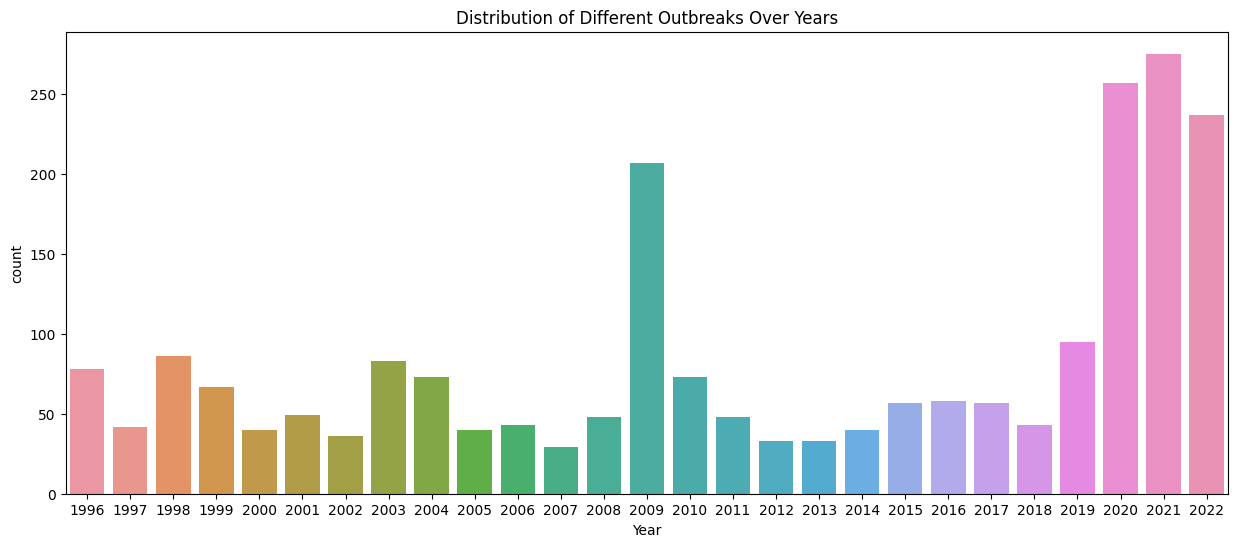

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(x='Year', data=outbreaks)
plt.title('Distribution of Different Outbreaks Over Years')
plt.show()

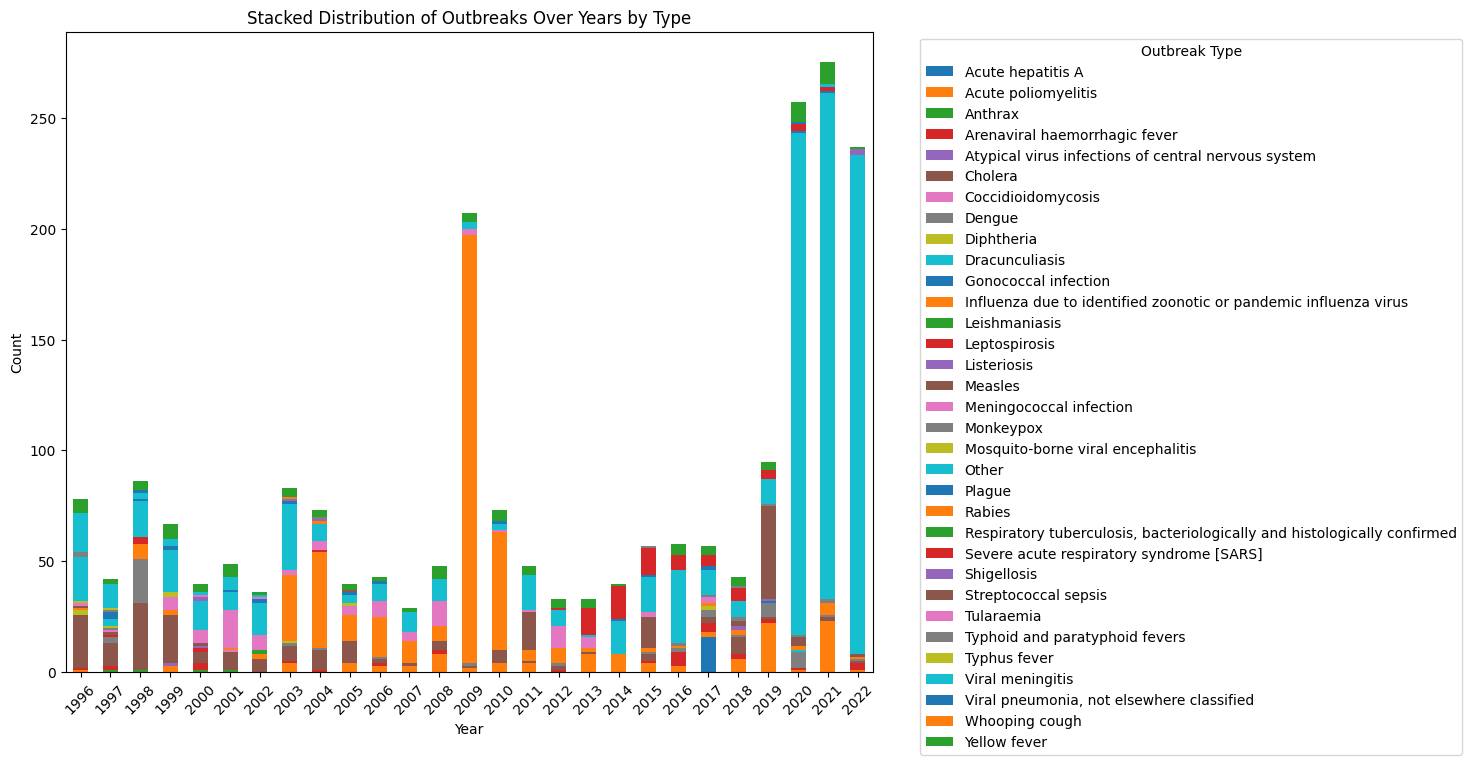

In [ ]:
outbreaks['icd103n_categorized'] = outbreaks['icd103n'].apply(
    lambda x: 'Other' if 'other' in x.lower() or 'unspecified' in x.lower() or 'emergency' in x.lower() else x
)

outbreaks['Year'] = outbreaks['Year'].astype(int)

pivot_df = outbreaks.pivot_table(index='Year', columns='icd103n_categorized', aggfunc='size', fill_value=0)
pivot_df.plot(kind='bar', stacked=True, figsize=(15, 8))

plt.title('Stacked Distribution of Outbreaks Over Years by Type')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Outbreak Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
negative_values = who_covid_data.iloc[:, -4:].lt(0).sum()
print("Negative values in the last four columns:\n", negative_values)

Negative values in the last four columns:
 Cumulative_cases      0
New_deaths           24
Cumulative_deaths     0
Year                  0
dtype: int64


In [ ]:
who_covid_data.iloc[:, -4:] = who_covid_data.iloc[:, -4:].abs()

negative_values_check = who_covid_data.iloc[:, -4:].lt(0).sum()
print("Negative values in the last four columns after conversion:\n", negative_values_check)

Negative values in the last four columns after conversion:
 Cumulative_cases     0
New_deaths           0
Cumulative_deaths    0
Year                 0
dtype: int64


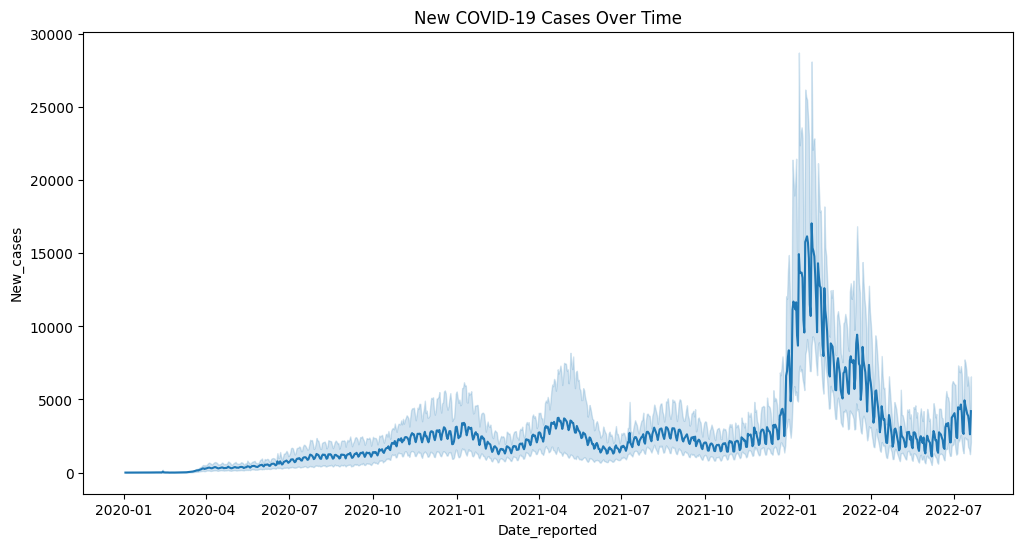

In [ ]:
who_covid_data['Date_reported'] = pd.to_datetime(who_covid_data['Date_reported'])
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date_reported', y='New_cases', data=who_covid_data)
plt.title('New COVID-19 Cases Over Time')
plt.show()

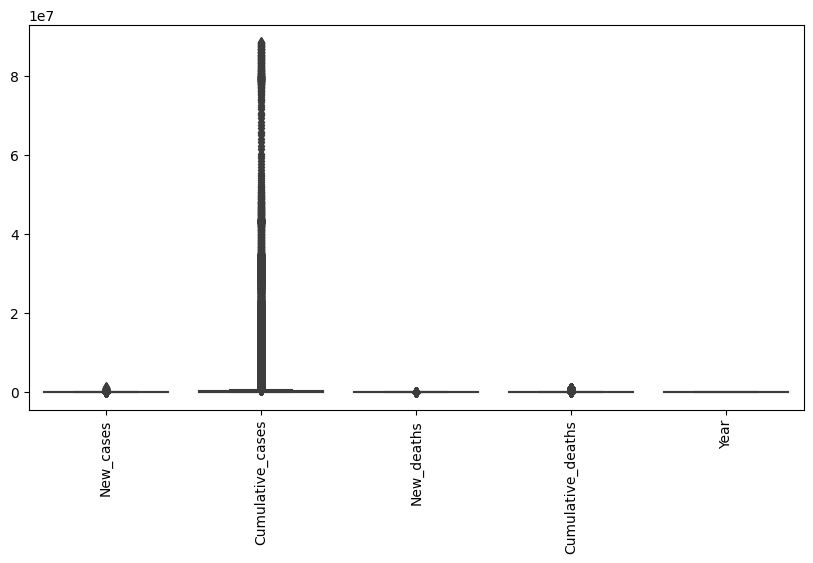

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(data=who_covid_data)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
daily_cases = who_covid_data.groupby('Date_reported')['New_cases'].sum().reset_index()
daily_cases.head()

,Date_reported,New_cases
0,2020-01-03,0
1,2020-01-04,3
2,2020-01-05,0
3,2020-01-06,3
4,2020-01-07,0


In [ ]:
daily_cases.sort_values(by='Date_reported')

,Date_reported,New_cases
0,2020-01-03,0
1,2020-01-04,3
2,2020-01-05,0
3,2020-01-06,3
4,2020-01-07,0
...,...,...
925,2022-07-16,947969
926,2022-07-17,919490
927,2022-07-18,805472
928,2022-07-19,619667


In [ ]:
adf_test = adfuller(daily_cases['New_cases'])
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

ADF Statistic: -2.560011867503852
p-value: 0.10154680713367087


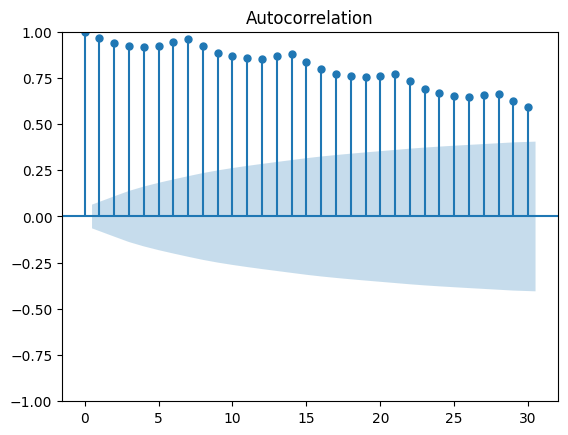

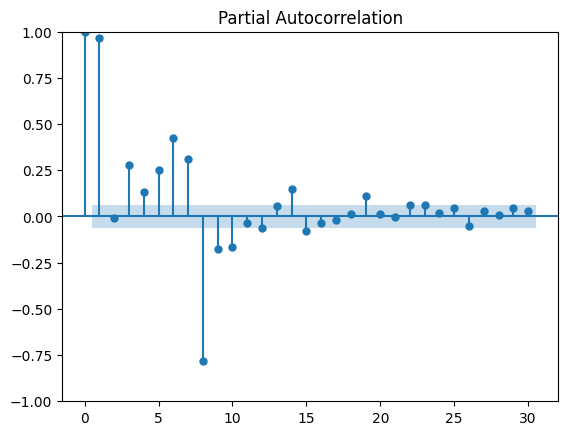

In [ ]:
plot_acf(daily_cases['New_cases'])
plot_pacf(daily_cases['New_cases'])
plt.show()

In [ ]:
# Differentiating the data to perhaps make it more stationary
daily_cases['New_cases_diff'] = daily_cases['New_cases'].diff()

# We may exclude them as differencing introduces NaN values (for the first element).
daily_cases.dropna(inplace=True)
daily_cases.head()

,Date_reported,New_cases,New_cases_diff
1,2020-01-04,3,3.0
2,2020-01-05,0,-3.0
3,2020-01-06,3,3.0
4,2020-01-07,0,-3.0
5,2020-01-08,0,0.0


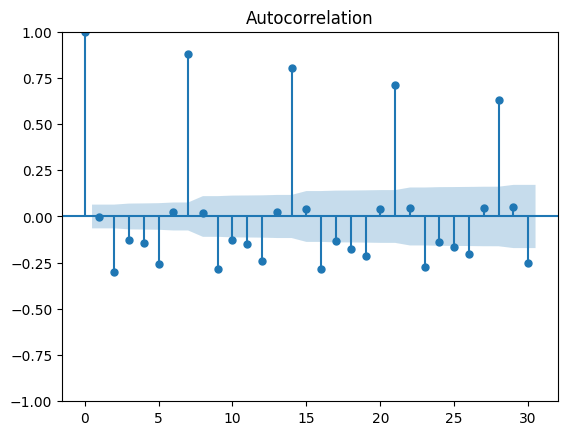

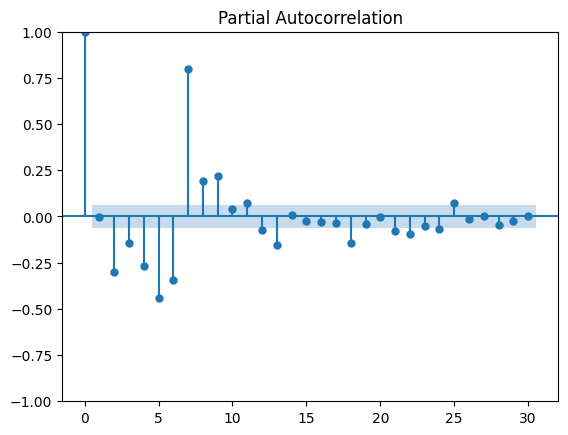

In [ ]:
plot_acf(daily_cases['New_cases_diff'])
plot_pacf(daily_cases['New_cases_diff'])
plt.show()

In [ ]:
def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
    print("5. Critical Values :")

    for key, val in dftest[4].items():
         print("\t",key, ": ", val)

In [ ]:
ad_test(daily_cases['New_cases'])

1. ADF :  -2.560349670893082
2. P-Value :  0.10147217286587396
3. Num Of Lags :  21
4. Num Of Observations Used For ADF Regression: 907
5. Critical Values :
	 1% :  -3.4375803238413085
	 5% :  -2.8647318597670877
	 10% :  -2.568469555703587


In [ ]:
stepwise_fit = auto_arima(daily_cases['New_cases'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=24682.446, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24864.531, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24866.517, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24866.498, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24862.574, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=24689.800, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=24691.385, Time=0.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=24652.342, Time=0.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=24686.002, Time=0.52 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=24595.793, Time=1.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=24611.635, Time=0.48 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=24140.868, Time=1.16 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=24473.565, Time=0.38 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=24129.478, Time=1.33 sec
 ARIMA(4,1,3)(0,0,0

In [ ]:
print(daily_cases.shape)
train=daily_cases.iloc[:-200]
test=daily_cases.iloc[-200:]
print(train.shape,test.shape)

(929, 3)
(729, 3) (200, 3)


In [ ]:
model = ARIMA(train['New_cases'], order=(5, 1, 5))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              New_cases   No. Observations:                  729
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -8747.574
Date:                Mon, 11 Dec 2023   AIC                          17517.148
Time:                        19:21:21   BIC                          17567.642
Sample:                             0   HQIC                         17536.631
                                - 729                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0798      0.237     -0.337      0.736      -0.544       0.384
ar.L2         -0.7290      0.181     -4.025      0.000      -1.084      -0.374
ar.L3         -0.4638      0.332     -1.397      0.162      -1.114       0.187
ar.L4         -0.2974      0.182     -1.630      0.103      -0.655       0.060
ar.L5         -0.8677      0.232     -3.738      0.000      -1.323      -0.413
ma.L1          0.0806      0.237      0.340      0.734      -0.384       0.546
ma.L2          0.6529      0.180      3.620      0.000       0.299       1.006
ma.L3          0.5339      0.310      1.724      0.085      -0.073       1.141
ma.L4          0.0532      0.157      0.340      0.734      -0.254       0.360
ma.L5          0.6381      0.156      4.086      0.000       0.332       0.944
sigma2      2.291e+09   7.71e-10   2.97e+18      0.000    2.29e+09    2.29e+09
===================================================================================
Ljung-Box (L1) (Q):                   5.19   Jarque-Bera (JB):             91649.62
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              48.64   Skew:                             4.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.45e+35. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

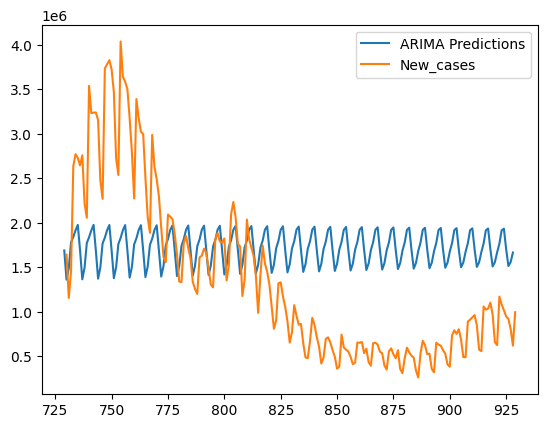

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model_fit.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['New_cases'].plot(legend=True)

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
print(test['New_cases'].mean())
rmse=sqrt(mean_squared_error(pred,test['New_cases']))
print(rmse)

1367791.495
982940.9354948788


In [ ]:
ad_test(daily_cases['New_cases_diff'])

1. ADF :  -6.674607558080266
2. P-Value :  4.498055544186218e-09
3. Num Of Lags :  21
4. Num Of Observations Used For ADF Regression: 907
5. Critical Values :
	 1% :  -3.4375803238413085
	 5% :  -2.8647318597670877
	 10% :  -2.568469555703587


In [ ]:
stepwise_fit = auto_arima(daily_cases['New_cases_diff'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=24708.268, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=24890.320, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24892.306, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=24892.287, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=24888.363, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=24715.722, Time=0.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=24717.177, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=24678.160, Time=0.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=24711.794, Time=0.23 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=24621.604, Time=0.71 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=24637.428, Time=0.26 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=24166.694, Time=1.07 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=24499.353, Time=0.36 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=24155.296, Time=1.24 sec
 ARIMA(4,0,3)(0,0,0

In [ ]:
print(daily_cases.shape)
train=daily_cases.iloc[:-200]
test=daily_cases.iloc[-200:]
print(train.shape,test.shape)

(929, 3)
(729, 3) (200, 3)


In [ ]:
model = ARIMA(train['New_cases_diff'], order=(5, 0, 5))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         New_cases_diff   No. Observations:                  729
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -8756.798
Date:                Mon, 11 Dec 2023   AIC                          17537.596
Time:                        19:22:08   BIC                          17592.696
Sample:                             0   HQIC                         17558.855
                                - 729                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2716.7764   2386.318      1.138      0.255   -1960.321    7393.873
ar.L1         -0.0821      0.210     -0.391      0.696      -0.494       0.330
ar.L2         -0.7258      0.160     -4.531      0.000      -1.040      -0.412
ar.L3         -0.4672      0.294     -1.589      0.112      -1.043       0.109
ar.L4         -0.2967      0.161     -1.839      0.066      -0.613       0.019
ar.L5         -0.8679      0.206     -4.204      0.000      -1.273      -0.463
ma.L1          0.0739      0.210      0.352      0.725      -0.338       0.486
ma.L2          0.6460      0.161      4.004      0.000       0.330       0.962
ma.L3          0.5371      0.274      1.961      0.050       0.000       1.074
ma.L4          0.0495      0.140      0.354      0.723      -0.224       0.323
ma.L5          0.6452      0.140      4.594      0.000       0.370       0.920
sigma2      2.255e+09      0.015    1.5e+11      0.000    2.25e+09    2.25e+09
===================================================================================
Ljung-Box (L1) (Q):                   4.02   Jarque-Bera (JB):             94562.23
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):              50.51   Skew:                             4.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.76e+25. Standard errors may be unstable.
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

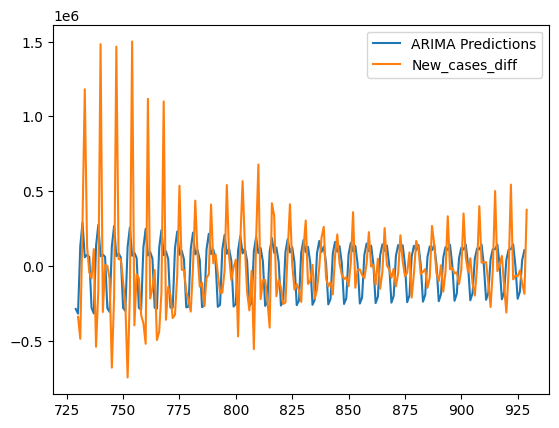

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model_fit.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['New_cases_diff'].plot(legend=True)

In [ ]:
daily_cases['Log_New_cases'] = np.log(daily_cases['New_cases'] + 1)

In [ ]:
daily_cases['Log_New_cases_diff'] = daily_cases['Log_New_cases'].diff().dropna()

In [ ]:
daily_cases_log= daily_cases[1:]

In [ ]:
ad_test(daily_cases_log['Log_New_cases_diff'])

1. ADF :  -7.006182467843158
2. P-Value :  7.112381146842793e-10
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 912
5. Critical Values :
	 1% :  -3.4375405714950604
	 5% :  -2.8647143318899913
	 10% :  -2.5684602193463375


In [ ]:
stepwise_fit = auto_arima(daily_cases_log['Log_New_cases_diff'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1100.706, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=692.407, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1098.725, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=553.532, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=540.119, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=491.386, Time=0.39 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=373.672, Time=0.45 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=117.832, Time=1.65 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=176.802, Time=1.21 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=73.036, Time=1.85 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=216.648, Time=1.48 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=83.126, Time=2.22 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=133.053, Time

In [ ]:
print(daily_cases_log.shape)
train=daily_cases_log.iloc[:-200]
test=daily_cases_log.iloc[-200:]
print(train.shape,test.shape)

(928, 5)
(728, 5) (200, 5)


In [ ]:
model = ARIMA(train['Log_New_cases_diff'], order=(5, 1, 4))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     Log_New_cases_diff   No. Observations:                  728
Model:                 ARIMA(5, 1, 4)   Log Likelihood                 -36.085
Date:                Mon, 11 Dec 2023   AIC                             92.170
Time:                        19:23:01   BIC                            138.059
Sample:                             0   HQIC                           109.878
                                - 728                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4295      0.020    -21.797      0.000      -0.468      -0.391
ar.L2          0.1022      0.016      6.309      0.000       0.070       0.134
ar.L3         -0.7126      0.013    -54.851      0.000      -0.738      -0.687
ar.L4         -0.5657      0.014    -40.761      0.000      -0.593      -0.538
ar.L5         -0.3135      0.015    -21.537      0.000      -0.342      -0.285
ma.L1         -0.9508      0.023    -40.804      0.000      -0.996      -0.905
ma.L2         -0.1448      0.024     -5.913      0.000      -0.193      -0.097
ma.L3          0.9392      0.022     41.853      0.000       0.895       0.983
ma.L4         -0.6676      0.018    -37.586      0.000      -0.702      -0.633
sigma2         0.0642      0.001     69.169      0.000       0.062       0.066
===================================================================================
Ljung-Box (L1) (Q):                   3.68   Jarque-Bera (JB):             61806.55
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             2.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

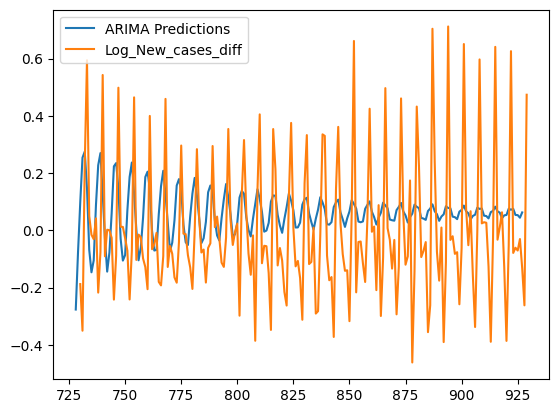

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model_fit.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['Log_New_cases_diff'].plot(legend=True)

In [ ]:
# Loading and preparing the data
df_prophet = daily_cases.rename(columns={'Date_reported': 'ds', 'New_cases': 'y'})

# Setting up and adjusting the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/ge5vs2e2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/7mvzgex5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30334', 'data', 'file=/tmp/tmp8r5lp1il/ge5vs2e2.json', 'init=/tmp/tmp8r5lp1il/7mvzgex5.json', 'output', 'file=/tmp/tmp8r5lp1il/prophet_modell0bicysj/prophet_model-20231211192306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:23:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

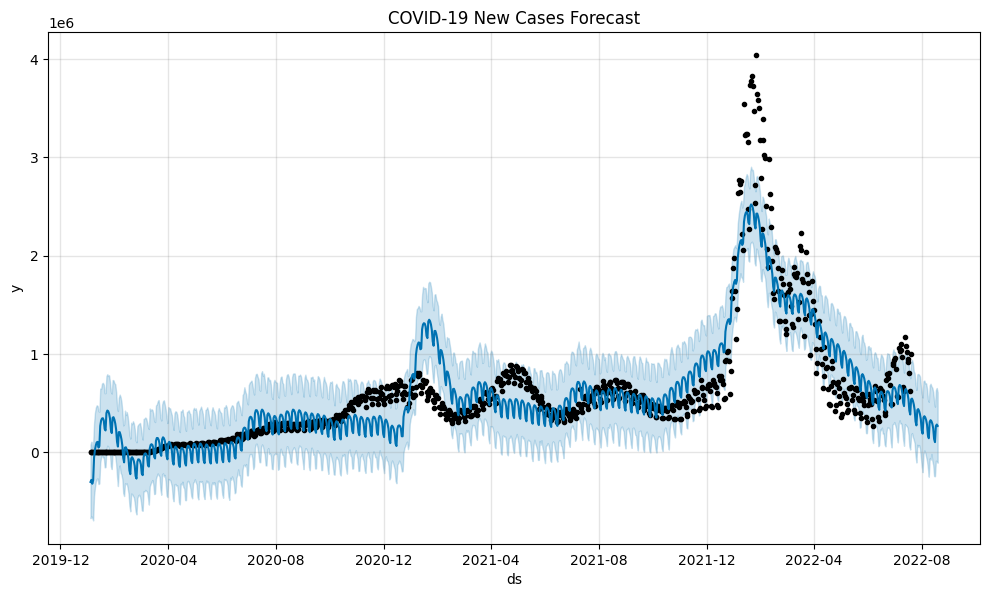

In [ ]:
fig1 = model.plot(forecast)
plt.title('COVID-19 New Cases Forecast')
plt.show()

In [ ]:
df_cv = cross_validation(model, initial='300 days', period='30 days', horizon='60 days')
df_performance = performance_metrics(df_cv)

INFO:prophet:Making 19 forecasts with cutoffs between 2020-11-27 00:00:00 and 2022-05-21 00:00:00


  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/nv_jqins.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/zagnr7_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33034', 'data', 'file=/tmp/tmp8r5lp1il/nv_jqins.json', 'init=/tmp/tmp8r5lp1il/zagnr7_p.json', 'output', 'file=/tmp/tmp8r5lp1il/prophet_modelm8rsmrqr/prophet_model-20231211192315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:23:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:23:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/6nyusl70.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/7dsz2oda.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,1.871564e+11,4.326157e+05,272675.705747,0.348864,0.191090,0.272103,0.228070
1,7 days,2.077637e+11,4.558111e+05,291227.385768,0.372851,0.216844,0.290121,0.192982
2,8 days,2.265158e+11,4.759368e+05,304114.675735,0.382384,0.221408,0.298844,0.201754
3,9 days,2.598270e+11,5.097323e+05,327626.357196,0.404057,0.236155,0.315592,0.210526
4,10 days,2.894469e+11,5.380027e+05,349804.284437,0.425781,0.267254,0.334182,0.201754
5,11 days,2.929307e+11,5.412307e+05,357529.313946,0.459490,0.286370,0.353892,0.175439
6,12 days,3.021825e+11,5.497113e+05,367786.617378,0.486581,0.298720,0.369453,0.157895
7,13 days,3.083332e+11,5.552776e+05,373510.519881,0.500951,0.308116,0.379077,0.157895
8,14 days,3.481268e+11,5.900227e+05,393162.817303,0.528884,0.315074,0.398924,0.157895
9,15 days,3.820219e+11,6.180792e+05,406230.227719,0.535629,0.320997,0.406901,0.175439


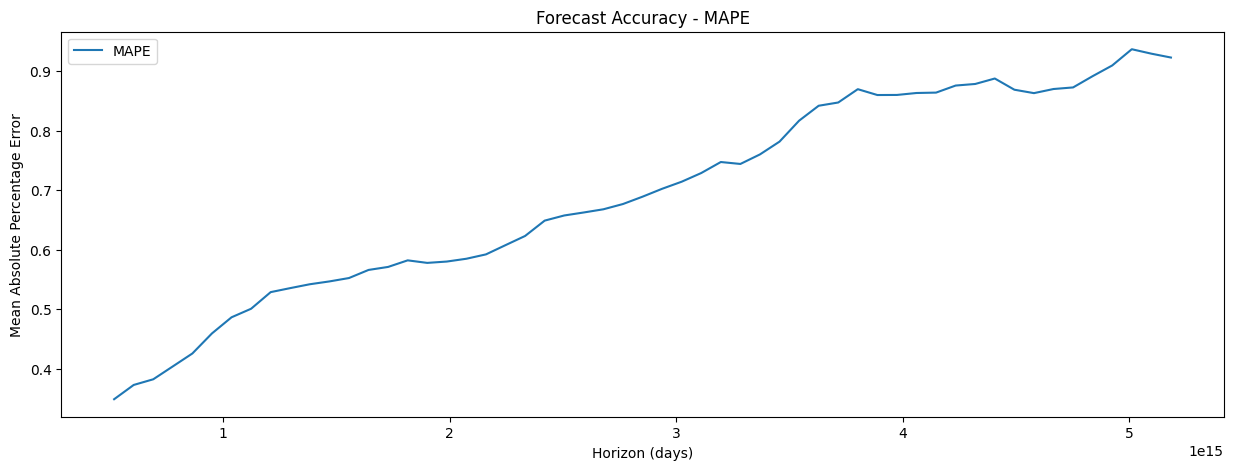

In [ ]:
fig2 = plt.figure(figsize=(15, 5))
plt.plot(df_performance['horizon'], df_performance['mape'], label='MAPE')
plt.title('Forecast Accuracy - MAPE')
plt.xlabel('Horizon (days)')
plt.ylabel('Mean Absolute Percentage Error')
plt.legend()
plt.show()

In [ ]:
print(df_performance[['horizon', 'mape']].head())

  horizon      mape
0  6 days  0.348864
1  7 days  0.372851
2  8 days  0.382384
3  9 days  0.404057
4 10 days  0.425781


In [ ]:
# Load and prepare data
df_prophet = daily_cases.rename(columns={'Date_reported': 'ds', 'Log_New_cases': 'y'})

# Initialize and fit Prophet model
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/sfxede9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/kbs4k1pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65459', 'data', 'file=/tmp/tmp8r5lp1il/sfxede9q.json', 'init=/tmp/tmp8r5lp1il/kbs4k1pt.json', 'output', 'file=/tmp/tmp8r5lp1il/prophet_modelxrk89bt8/prophet_model-20231211193555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

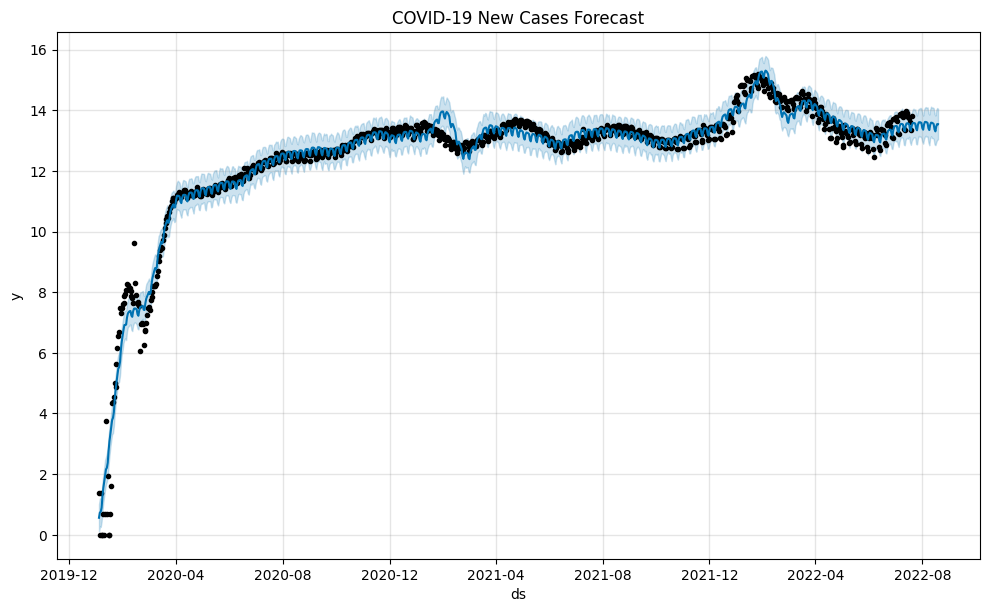

In [ ]:
fig1 = model.plot(forecast)
plt.title('COVID-19 New Cases Forecast')
plt.show()

In [ ]:
df_cv = cross_validation(model, initial='300 days', period='30 days', horizon='60 days')
df_performance = performance_metrics(df_cv)

INFO:prophet:Making 19 forecasts with cutoffs between 2020-11-27 00:00:00 and 2022-05-21 00:00:00


  0%|          | 0/19 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/bjjdduir.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/5c5e0aw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27986', 'data', 'file=/tmp/tmp8r5lp1il/bjjdduir.json', 'init=/tmp/tmp8r5lp1il/5c5e0aw5.json', 'output', 'file=/tmp/tmp8r5lp1il/prophet_modelhz_24jq7/prophet_model-20231211193600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/fi9lymjq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/uaxchvu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,6 days,0.569489,0.754645,0.522554,0.038775,0.027606,0.037904,0.640351
1,7 days,0.683634,0.826822,0.568996,0.042179,0.029642,0.041128,0.614035
2,8 days,0.795061,0.891662,0.607268,0.044971,0.028968,0.043753,0.605263
3,9 days,0.917809,0.958023,0.643423,0.047588,0.030068,0.046190,0.614035
4,10 days,1.046465,1.022969,0.678857,0.050128,0.031542,0.048563,0.605263
5,11 days,1.192799,1.092153,0.728133,0.053751,0.034533,0.051974,0.570175
6,12 days,1.316176,1.147247,0.772436,0.057016,0.036976,0.055052,0.535088
7,13 days,1.434922,1.197882,0.812680,0.059982,0.038506,0.057839,0.508772
8,14 days,1.566223,1.251488,0.846805,0.062481,0.038880,0.060173,0.508772
9,15 days,1.669352,1.292034,0.873208,0.064426,0.038880,0.061989,0.508772


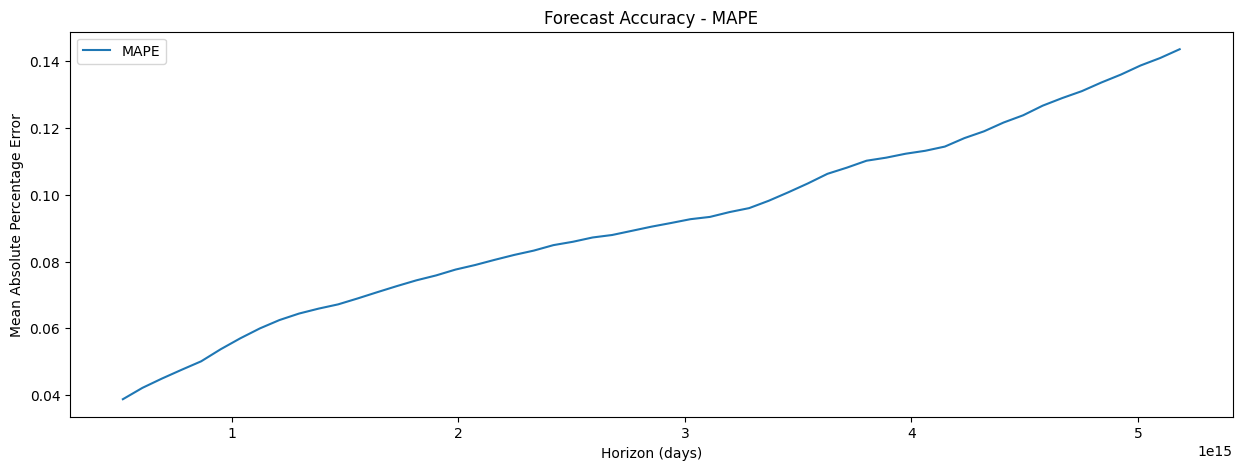

In [ ]:
fig2 = plt.figure(figsize=(15, 5))
plt.plot(df_performance['horizon'], df_performance['mape'], label='MAPE')
plt.title('Forecast Accuracy - MAPE')
plt.xlabel('Horizon (days)')
plt.ylabel('Mean Absolute Percentage Error')
plt.legend()
plt.show()

Training model on "New Cases"

In [ ]:
daily_cases['Date_reported'] = pd.to_datetime(daily_cases['Date_reported'])
daily_cases.sort_values('Date_reported', inplace=True)

# Since 'New_cases' is the desired variable
data = daily_cases['New_cases'].values
data = data.reshape(-1, 1)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [ ]:
# Spliting the data into train and test sets
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

In [ ]:
# transforming a dataset matrix from an array of values
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)


In [ ]:
# Reshaping into X=t and Y=t+1
look_back = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshaping input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Designing and optimising the LSTM architecture
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

Epoch 1/100
49/49 - 3s - loss: 0.0101 - 3s/epoch - 56ms/step
Epoch 2/100
49/49 - 0s - loss: 0.0032 - 105ms/epoch - 2ms/step
Epoch 3/100
49/49 - 0s - loss: 0.0013 - 383ms/epoch - 8ms/step
Epoch 4/100
49/49 - 0s - loss: 0.0011 - 120ms/epoch - 2ms/step
Epoch 5/100
49/49 - 0s - loss: 0.0011 - 124ms/epoch - 3ms/step
Epoch 6/100
49/49 - 0s - loss: 0.0011 - 120ms/epoch - 2ms/step
Epoch 7/100
49/49 - 0s - loss: 9.0053e-04 - 151ms/epoch - 3ms/step
Epoch 8/100
49/49 - 0s - loss: 7.0368e-04 - 151ms/epoch - 3ms/step
Epoch 9/100
49/49 - 0s - loss: 6.9544e-04 - 148ms/epoch - 3ms/step
Epoch 10/100
49/49 - 0s - loss: 0.0011 - 136ms/epoch - 3ms/step
Epoch 11/100
49/49 - 0s - loss: 9.4221e-04 - 144ms/epoch - 3ms/step
Epoch 12/100
49/49 - 0s - loss: 8.6611e-04 - 151ms/epoch - 3ms/step
Epoch 13/100
49/49 - 0s - loss: 7.4898e-04 - 158ms/epoch - 3ms/step
Epoch 14/100
49/49 - 0s - loss: 0.0011 - 141ms/epoch - 3ms/step
Epoch 15/100
49/49 - 0s - loss: 7.8962e-04 - 130ms/epoch - 3ms/step
Epoch 16/100
49/49 - 0s

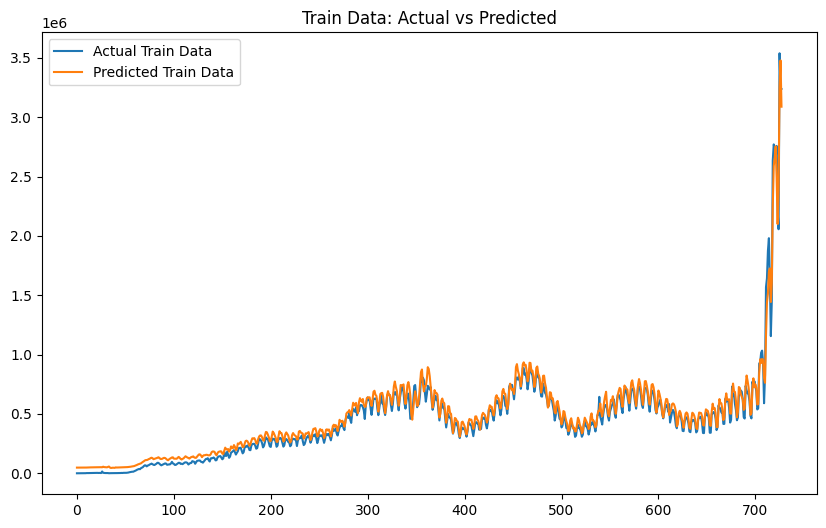

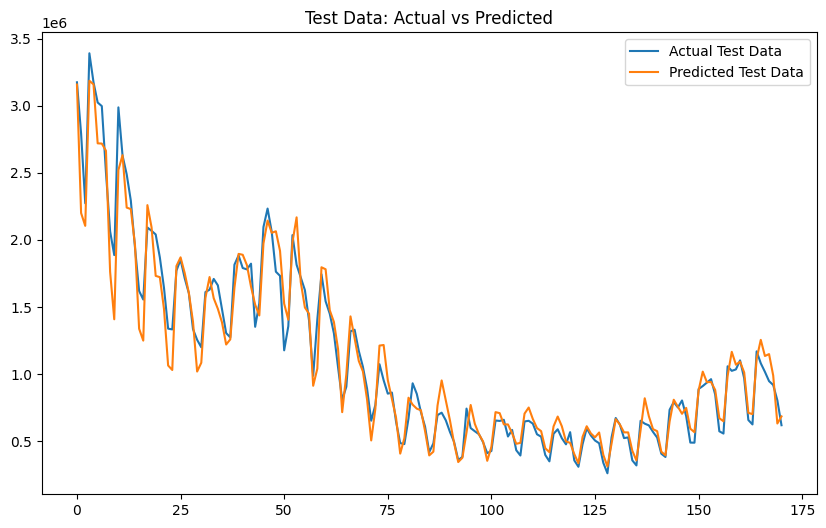

In [ ]:

# Training the model
model.fit(X_train, Y_train, epochs=100, batch_size=15, verbose=2)

# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverting predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train_inverted = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inverted = scaler.inverse_transform([Y_test])

# Calculating RMSE
train_score = np.sqrt(mean_squared_error(Y_train_inverted[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(Y_test_inverted[0], test_predict[:, 0]))
print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

# Determining the Accuracy and MAPE.
mape_train = mean_absolute_percentage_error(Y_train_inverted[0], train_predict[:, 0])
mape_test = mean_absolute_percentage_error(Y_test_inverted[0], test_predict[:, 0])
accuracy_train = 100 - mape_train * 100
accuracy_test = 100 - mape_test * 100
print(f'Train Accuracy: {accuracy_train:.2f}%')
print(f'Test Accuracy: {accuracy_test:.2f}%')

# Plotting Predictions vs Actual Data
plt.figure(figsize=(10,6))
plt.plot(Y_train_inverted[0], label='Actual Train Data')
plt.plot(train_predict[:, 0], label='Predicted Train Data')
plt.title('Train Data: Actual vs Predicted')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(Y_test_inverted[0], label='Actual Test Data')
plt.plot(test_predict[:, 0], label='Predicted Test Data')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.show()


In [ ]:
df_uk = who_covid_data[who_covid_data['Country'] == 'The United Kingdom']
df_uk.shape

(930, 9)

In [ ]:
who_covid_data.Country.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Anguilla', 'Antigua and Barbuda', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bonaire',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', 'Côte d’Ivoire', 'Croatia', 'Cuba', 'Curaçao',
       'Cyprus', 'Czechia', "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvado

In [ ]:
# Sorting by 'Country' and adding up the 'New_cases'
country_cases = who_covid_data.groupby('Country').agg({'New_cases': 'sum'})

# Finding the top ten nations with the most instances by sorting the values
top_countries = country_cases.sort_values('New_cases', ascending=False).head(10)

# Displaying the top 10 countries
top_countries

,New_cases
Country,
United States of America,88544725
India,43803619
Brazil,33339815
France,32210617
Germany,29994679
The United Kingdom,23075360
Italy,20299013
Republic of Korea,18937971
Russian Federation,18504729


In [ ]:

df = who_covid_data

# List of countries for forecasting
countries = ['United States of America', 'India','Brazil','France','Germany','The United Kingdom','Italy','Republic of Korea','Russian Federation','Türkiye']

# A dictionary to hold forecasts for each country
country_forecasts = {}

# LSTM model configuration
look_back = 14
epochs = 100
batch_size = 9

# serve as the basis for the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Function to prepare the data for the LSTM model
def prepare_data(country_df, look_back):
    # Scaling the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(country_df['New_cases'].values.reshape(-1, 1))

    X, Y = [], []
    for i in range(len(scaled_data)-look_back):
        a = scaled_data[i:(i+look_back), 0]
        X.append(a)
        Y.append(scaled_data[i + look_back, 0])
    X, Y = np.array(X), np.array(Y)

    # Reshaping input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

    return X, Y, scaler

In [ ]:

# projections for every nation
for country in countries:
    # Filtering the dataset for the selected country
    country_df = df[df['Country'] == country]
    country_df.sort_values('Date_reported', inplace=True)

    # Preparing the data for the LSTM model
    X, Y, scaler = prepare_data(country_df, look_back)

    # Creating the LSTM model
    model = create_lstm_model((1, look_back))

    # Training the model
    model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=2)

    # Forecast the next 30 days
    last_known_batch = X[-1].reshape(1, 1, look_back)
    forecast = []
    for i in range(30):  # Forecasting for 30 days
        current_pred = model.predict(last_known_batch)[0]
        forecast.append(current_pred)
        last_known_batch = np.append(last_known_batch[:, :, 1:], [[current_pred]], axis=2)

    # Inverting the forecast to the original scale
    forecast = scaler.inverse_transform(forecast)

    # Storing the forecast in the dictionary
    country_forecasts[country] = forecast.ravel()

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 5s - loss: 0.0054 - 5s/epoch - 48ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0030 - 306ms/epoch - 3ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0024 - 260ms/epoch - 3ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0016 - 250ms/epoch - 2ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0020 - 257ms/epoch - 3ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0012 - 252ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0012 - 240ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0010 - 227ms/epoch - 2ms/step
Epoch 9/100
102/102 - 0s - loss: 9.8091e-04 - 251ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 0.0011 - 269ms/epoch - 3ms/step
Epoch 11/100
102/102 - 0s - loss: 0.0011 - 259ms/epoch - 3ms/step
Epoch 12/100
102/102 - 0s - loss: 8.7801e-04 - 266ms/epoch - 3ms/step
Epoch 13/100
102/102 - 0s - loss: 8.8497e-04 - 259ms/epoch - 3ms/step
Epoch 14/100
102/102 - 0s - loss: 9.3145e-04 - 241ms/epoch - 2ms/step
Epoch 15/100
102/102 - 0s - loss: 8.1321e-04 - 232ms/epoch - 2ms/step
E

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0128 - 3s/epoch - 27ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0039 - 248ms/epoch - 2ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0022 - 269ms/epoch - 3ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0016 - 255ms/epoch - 3ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0014 - 244ms/epoch - 2ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0014 - 245ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0013 - 238ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0014 - 238ms/epoch - 2ms/step
Epoch 9/100
102/102 - 0s - loss: 0.0015 - 245ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 0.0011 - 247ms/epoch - 2ms/step
Epoch 11/100
102/102 - 0s - loss: 0.0012 - 250ms/epoch - 2ms/step
Epoch 12/100
102/102 - 0s - loss: 9.5992e-04 - 236ms/epoch - 2ms/step
Epoch 13/100
102/102 - 0s - loss: 0.0012 - 240ms/epoch - 2ms/step
Epoch 14/100
102/102 - 0s - loss: 0.0011 - 260ms/epoch - 3ms/step
Epoch 15/100
102/102 - 0s - loss: 0.0012 - 238ms/epoch - 2ms/step
Epoch 16/100
102/

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0099 - 3s/epoch - 28ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0043 - 241ms/epoch - 2ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0040 - 238ms/epoch - 2ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0038 - 231ms/epoch - 2ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0031 - 240ms/epoch - 2ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0031 - 240ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0033 - 245ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0029 - 249ms/epoch - 2ms/step
Epoch 9/100
102/102 - 0s - loss: 0.0032 - 234ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 0.0027 - 248ms/epoch - 2ms/step
Epoch 11/100
102/102 - 0s - loss: 0.0025 - 231ms/epoch - 2ms/step
Epoch 12/100
102/102 - 0s - loss: 0.0028 - 226ms/epoch - 2ms/step
Epoch 13/100
102/102 - 0s - loss: 0.0029 - 229ms/epoch - 2ms/step
Epoch 14/100
102/102 - 0s - loss: 0.0028 - 268ms/epoch - 3ms/step
Epoch 15/100
102/102 - 0s - loss: 0.0026 - 251ms/epoch - 2ms/step
Epoch 16/100
102/102 

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0105 - 3s/epoch - 33ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0045 - 239ms/epoch - 2ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0037 - 306ms/epoch - 3ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0035 - 295ms/epoch - 3ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0021 - 315ms/epoch - 3ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0024 - 299ms/epoch - 3ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0021 - 259ms/epoch - 3ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0020 - 285ms/epoch - 3ms/step
Epoch 9/100
102/102 - 0s - loss: 0.0018 - 331ms/epoch - 3ms/step
Epoch 10/100
102/102 - 0s - loss: 0.0018 - 322ms/epoch - 3ms/step
Epoch 11/100
102/102 - 0s - loss: 0.0015 - 371ms/epoch - 4ms/step
Epoch 12/100
102/102 - 0s - loss: 0.0016 - 244ms/epoch - 2ms/step
Epoch 13/100
102/102 - 0s - loss: 0.0017 - 248ms/epoch - 2ms/step
Epoch 14/100
102/102 - 0s - loss: 0.0017 - 253ms/epoch - 2ms/step
Epoch 15/100
102/102 - 0s - loss: 0.0016 - 244ms/epoch - 2ms/step
Epoch 16/100
102/102 

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0179 - 3s/epoch - 27ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0049 - 261ms/epoch - 3ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0033 - 264ms/epoch - 3ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0029 - 248ms/epoch - 2ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0026 - 248ms/epoch - 2ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0024 - 245ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0022 - 244ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0020 - 256ms/epoch - 3ms/step
Epoch 9/100
102/102 - 0s - loss: 0.0017 - 249ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 0.0018 - 261ms/epoch - 3ms/step
Epoch 11/100
102/102 - 0s - loss: 0.0018 - 260ms/epoch - 3ms/step
Epoch 12/100
102/102 - 0s - loss: 0.0018 - 265ms/epoch - 3ms/step
Epoch 13/100
102/102 - 0s - loss: 0.0020 - 240ms/epoch - 2ms/step
Epoch 14/100
102/102 - 0s - loss: 0.0019 - 243ms/epoch - 2ms/step
Epoch 15/100
102/102 - 0s - loss: 0.0016 - 274ms/epoch - 3ms/step
Epoch 16/100
102/102 

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0068 - 3s/epoch - 27ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0031 - 233ms/epoch - 2ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0028 - 270ms/epoch - 3ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0025 - 251ms/epoch - 2ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0016 - 237ms/epoch - 2ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0015 - 229ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0016 - 228ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0014 - 254ms/epoch - 2ms/step
Epoch 9/100
102/102 - 0s - loss: 0.0012 - 233ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 0.0015 - 236ms/epoch - 2ms/step
Epoch 11/100
102/102 - 0s - loss: 0.0012 - 264ms/epoch - 3ms/step
Epoch 12/100
102/102 - 0s - loss: 0.0014 - 256ms/epoch - 3ms/step
Epoch 13/100
102/102 - 0s - loss: 9.9128e-04 - 244ms/epoch - 2ms/step
Epoch 14/100
102/102 - 0s - loss: 0.0012 - 234ms/epoch - 2ms/step
Epoch 15/100
102/102 - 0s - loss: 0.0011 - 254ms/epoch - 2ms/step
Epoch 16/100
102/

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0131 - 3s/epoch - 27ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0041 - 248ms/epoch - 2ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0045 - 251ms/epoch - 2ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0035 - 240ms/epoch - 2ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0035 - 239ms/epoch - 2ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0032 - 247ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0030 - 243ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0023 - 238ms/epoch - 2ms/step
Epoch 9/100
102/102 - 0s - loss: 0.0019 - 283ms/epoch - 3ms/step
Epoch 10/100
102/102 - 0s - loss: 0.0021 - 279ms/epoch - 3ms/step
Epoch 11/100
102/102 - 0s - loss: 0.0023 - 288ms/epoch - 3ms/step
Epoch 12/100
102/102 - 0s - loss: 0.0019 - 288ms/epoch - 3ms/step
Epoch 13/100
102/102 - 0s - loss: 0.0022 - 308ms/epoch - 3ms/step
Epoch 14/100
102/102 - 0s - loss: 0.0022 - 286ms/epoch - 3ms/step
Epoch 15/100
102/102 - 0s - loss: 0.0019 - 287ms/epoch - 3ms/step
Epoch 16/100
102/102 

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0056 - 3s/epoch - 31ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0020 - 223ms/epoch - 2ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0016 - 241ms/epoch - 2ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0015 - 245ms/epoch - 2ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0013 - 255ms/epoch - 3ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0012 - 246ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0010 - 238ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0012 - 239ms/epoch - 2ms/step
Epoch 9/100
102/102 - 0s - loss: 8.6335e-04 - 234ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 7.1878e-04 - 247ms/epoch - 2ms/step
Epoch 11/100
102/102 - 0s - loss: 9.3141e-04 - 243ms/epoch - 2ms/step
Epoch 12/100
102/102 - 0s - loss: 8.4995e-04 - 243ms/epoch - 2ms/step
Epoch 13/100
102/102 - 0s - loss: 9.6866e-04 - 237ms/epoch - 2ms/step
Epoch 14/100
102/102 - 0s - loss: 7.0054e-04 - 256ms/epoch - 3ms/step
Epoch 15/100
102/102 - 0s - loss: 8.9929e-04 - 239ms/epoch - 2m

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0105 - 3s/epoch - 27ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0035 - 234ms/epoch - 2ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0018 - 236ms/epoch - 2ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0014 - 249ms/epoch - 2ms/step
Epoch 5/100
102/102 - 0s - loss: 8.6929e-04 - 241ms/epoch - 2ms/step
Epoch 6/100
102/102 - 0s - loss: 6.4916e-04 - 246ms/epoch - 2ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0010 - 240ms/epoch - 2ms/step
Epoch 8/100
102/102 - 0s - loss: 9.0845e-04 - 243ms/epoch - 2ms/step
Epoch 9/100
102/102 - 0s - loss: 5.4856e-04 - 247ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 9.4615e-04 - 245ms/epoch - 2ms/step
Epoch 11/100
102/102 - 0s - loss: 6.5424e-04 - 233ms/epoch - 2ms/step
Epoch 12/100
102/102 - 0s - loss: 5.3319e-04 - 259ms/epoch - 3ms/step
Epoch 13/100
102/102 - 0s - loss: 5.6848e-04 - 236ms/epoch - 2ms/step
Epoch 14/100
102/102 - 0s - loss: 4.2220e-04 - 247ms/epoch - 2ms/step
Epoch 15/100
102/102 - 0s - loss: 5.8858e-04 - 243m

<ipython-input-105-79cfbd8b1ddb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df.sort_values('Date_reported', inplace=True)


Epoch 1/100
102/102 - 3s - loss: 0.0149 - 3s/epoch - 31ms/step
Epoch 2/100
102/102 - 0s - loss: 0.0045 - 291ms/epoch - 3ms/step
Epoch 3/100
102/102 - 0s - loss: 0.0039 - 288ms/epoch - 3ms/step
Epoch 4/100
102/102 - 0s - loss: 0.0037 - 318ms/epoch - 3ms/step
Epoch 5/100
102/102 - 0s - loss: 0.0033 - 324ms/epoch - 3ms/step
Epoch 6/100
102/102 - 0s - loss: 0.0030 - 280ms/epoch - 3ms/step
Epoch 7/100
102/102 - 0s - loss: 0.0031 - 267ms/epoch - 3ms/step
Epoch 8/100
102/102 - 0s - loss: 0.0027 - 256ms/epoch - 3ms/step
Epoch 9/100
102/102 - 0s - loss: 0.0027 - 237ms/epoch - 2ms/step
Epoch 10/100
102/102 - 0s - loss: 0.0028 - 267ms/epoch - 3ms/step
Epoch 11/100
102/102 - 0s - loss: 0.0028 - 271ms/epoch - 3ms/step
Epoch 12/100
102/102 - 0s - loss: 0.0026 - 229ms/epoch - 2ms/step
Epoch 13/100
102/102 - 0s - loss: 0.0026 - 234ms/epoch - 2ms/step
Epoch 14/100
102/102 - 0s - loss: 0.0025 - 245ms/epoch - 2ms/step
Epoch 15/100
102/102 - 0s - loss: 0.0027 - 259ms/epoch - 3ms/step
Epoch 16/100
102/102 

In [ ]:
country_forecasts

{'United States of America': array([112190.36647341, 174638.49763191, 147276.21830009, 132528.91773203,
        155207.77905489,  51298.72243411,  41455.6431762 , 108471.59964222,
        173312.28356326, 153648.12443553, 141078.26734313, 158515.6504669 ,
         67742.77376569,  50994.80149586, 114271.70883648, 180859.63637435,
        168631.1955618 , 158130.08569153, 168324.45802814,  89375.74712314,
         67178.48150731, 125506.83657177, 193647.16669762, 187932.97769964,
        178455.31192733, 183848.80206157, 112517.98985744,  85615.80746865,
        138820.36842774, 207742.00902066]),
 'India': array([15571.48401964, 16318.44455336, 15396.4821196 , 13876.06188422,
        12046.89409382,  8579.37906159,  5650.93555079,  4602.55353925,
         4033.45867963,  2660.64624693,  1134.77620013,  -706.64595104,
        -3240.38856747, -5156.2719302 , -5675.33406475, -5538.41912534,
        -5660.8670682 , -5888.19765009, -6319.36228833, -7108.50485614,
        -7474.29644512, -68

In [ ]:
icu_units = pd.read_excel('/content/icu_units.xlsx')
health_exp = pd.read_excel('/content/Health_expen.xlsx')
bed_density = pd.read_excel('/content/Hospital_bed_density.xlsx')
hospital_beds = pd.read_excel('/content/hospital_beds.xlsx')
pop_density = pd.read_excel('/content/pop_den.xlsx')

In [ ]:
# icu_units.drop(columns=['Unnamed: 0'], inplace= True )
icu_units.head()

,Country,count
0,Czech Republic*,43.2
1,Türkiye,39.8
2,Estonia*,38.1
3,Germany,28.2
4,Austria*,21.8


In [ ]:
# health_exp.drop(columns=['Unnamed: 0'], inplace= True )
health_exp.head()

,Country,Percentage
0,United States of America,16.6
1,Germany,12.7
2,France,11.9
3,Japan,11.5
4,Austria,11.4


In [ ]:
# bed_density.drop(columns=['Unnamed: 0'], inplace= True )
bed_density.head()

,Country,Count
0,Republic of Korea,12.65
1,Japan,12.63
2,Russian Federation,8.00
3,Germany,7.82
4,Austria,7.05


In [ ]:
# hospital_beds.drop(columns=['Unnamed: 0'], inplace= True )
hospital_beds.head()

,Country,count
0,Colombia,10899
1,Japan,8238
2,United States of America,6090
3,Mexico,4909
4,Republic of Korea,4106


In [ ]:
# pop_density.drop(columns=['Unnamed: 0'], inplace= True )
pop_density.head()

,Country,Density
0,Monaco,24621.5
1,Macao SAR,21456.5
2,Singapore,8698.5
3,Hong Kong SAR,6819.5
4,Gibraltar,3267.0


In [ ]:
forecast_df = pd.DataFrame(country_forecasts).T
forecast_df.columns = [f'Day_{i+1}' for i in range(forecast_df.shape[1])]
forecast_df.reset_index(inplace=True)
forecast_df.rename(columns={'index': 'Country'}, inplace=True)

forecast_df.head(10)

,Country,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,...,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,United States of America,112190.366473,174638.497632,147276.218300,132528.917732,155207.779055,51298.722434,41455.643176,108471.599642,173312.283563,...,67178.481507,125506.836572,193647.166698,187932.977700,178455.311927,183848.802062,112517.989857,85615.807469,138820.368428,207742.009021
1,India,15571.484020,16318.444553,15396.482120,13876.061884,12046.894094,8579.379062,5650.935551,4602.553539,4033.458680,...,-7474.296445,-6873.181629,-5816.557009,-4922.855828,-4246.823078,-3892.980340,-3882.015911,-3712.007100,-3013.172166,-2081.442658
2,Brazil,50837.080712,78588.565044,82747.772570,82068.208573,94712.873071,55824.053267,27982.260531,57514.935054,86179.932959,...,56575.051365,71962.631184,100551.303218,112375.798741,115456.170465,116908.054975,96695.955704,71306.038013,81586.801363,108475.088746
3,France,144343.644369,115899.265246,98320.225931,24868.632842,115847.179259,80150.622669,30457.131816,140815.297977,128821.930686,...,93878.237769,182190.457899,196129.616845,181805.992752,110654.065364,197465.622789,178223.374894,140780.061803,220382.293542,243406.925427
4,Germany,152839.213278,136357.639911,129113.837834,102955.928485,22243.456153,13026.903592,118415.418691,154426.453912,140815.704141,...,105112.130792,149539.642576,143769.211798,138817.646559,98036.969366,7406.468300,-2965.658180,98057.640381,144946.680492,142241.811690
5,The United Kingdom,4578.723866,343.785412,-4801.728968,-3465.667892,-182.326720,3066.682119,7984.141257,13326.643990,12617.287117,...,46398.714397,50988.259407,50699.922857,47924.115707,47142.003124,49752.706198,54700.283398,60455.143789,63935.136501,62706.619397
6,Italy,116083.388612,93965.464492,83962.501028,72880.559716,61157.320517,43011.169699,22401.814760,87320.959462,72599.261041,...,2360.807081,48768.811584,48473.698164,37651.578764,30646.897758,22613.271466,9646.139195,-1079.067930,38535.443729,43047.528586
7,Republic of Korea,67823.279420,62840.822231,69836.523616,70028.554344,68305.694015,66624.756212,96652.044156,101380.549710,93802.765884,...,167144.616438,172313.567768,171976.132160,180175.819273,181911.511895,177399.155485,186554.209591,200330.148346,202889.089044,203449.913949
8,Russian Federation,4795.444573,5177.584184,5526.813630,5677.235782,5690.344840,5654.734456,5710.496959,5917.421629,6208.983071,...,7927.397208,8037.744571,8196.147339,8368.487313,8514.037824,8610.416071,8670.655134,8723.121758,8795.106094,8893.501527
9,Türkiye,-5759.212054,-24805.244710,-23195.905385,-24734.881830,6335.622864,-7260.471789,-6859.899258,-11620.820716,-26456.191764,...,-3160.140629,-2054.717898,-27640.443395,-28434.542747,-43372.959489,-4524.794198,-12289.739189,-3431.292292,1770.891633,-27954.188627


In [ ]:
combined_df = forecast_df
combined_df = combined_df.merge(icu_units, on='Country', how='left')
combined_df = combined_df.merge(health_exp, on='Country', how='left')
combined_df = combined_df.merge(bed_density, on='Country', how='left')
combined_df = combined_df.merge(hospital_beds, on='Country', how='left')
combined_df = combined_df.merge(pop_density, on='Country', how='left')


In [ ]:
#combined_df = combined_df.drop(7)

In [ ]:
combined_df = combined_df.rename(columns={
    'count_x':'icu_100k',
    'Percentage': 'GDP_medical',
    'Count': 'density_1k',
    'count_y': 'hospitals',
    'Density': 'pop_density'
})

In [ ]:
combined_df.to_csv('/content/classification.csv', sep = ',',index = False)

In [ ]:
combined_df=combined_df.drop(7)

In [ ]:
combined_df.head(10)

,Country,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,...,Day_26,Day_27,Day_28,Day_29,Day_30,icu_100k,GDP_medical,density_1k,hospitals,pop_density
0,United States of America,112190.366473,174638.497632,147276.218300,132528.917732,155207.779055,51298.722434,41455.643176,108471.599642,173312.283563,...,183848.802062,112517.989857,85615.807469,138820.368428,207742.009021,21.6,16.6,2.80,6090,37.00
1,India,15571.484020,16318.444553,15396.482120,13876.061884,12046.894094,8579.379062,5650.935551,4602.553539,4033.458680,...,-3892.980340,-3882.015911,-3712.007100,-3013.172166,-2081.442658,1.5,3.0,0.53,69000,473.40
2,Brazil,50837.080712,78588.565044,82747.772570,82068.208573,94712.873071,55824.053267,27982.260531,57514.935054,86179.932959,...,116908.054975,96695.955704,71306.038013,81586.801363,108475.088746,2.7,2.8,1.91,7191,25.41
3,France,144343.644369,115899.265246,98320.225931,24868.632842,115847.179259,80150.622669,30457.131816,140815.297977,128821.930686,...,197465.622789,178223.374894,140780.061803,220382.293542,243406.925427,16.4,11.9,5.73,2989,118.00
4,Germany,152839.213278,136357.639911,129113.837834,102955.928485,22243.456153,13026.903592,118415.418691,154426.453912,140815.704141,...,7406.468300,-2965.658180,98057.640381,144946.680492,142241.811690,28.2,12.7,7.82,3006,239.00
5,The United Kingdom,4578.723866,343.785412,-4801.728968,-3465.667892,-182.326720,3066.682119,7984.141257,13326.643990,12617.287117,...,49752.706198,54700.283398,60455.143789,63935.136501,62706.619397,7.3,11.3,2.43,1921,280.00
6,Italy,116083.388612,93965.464492,83962.501028,72880.559716,61157.320517,43011.169699,22401.814760,87320.959462,72599.261041,...,22613.271466,9646.139195,-1079.067930,38535.443729,43047.528586,8.7,9.0,3.19,1065,195.00
8,Republic of Korea,67823.279420,62840.822231,69836.523616,70028.554344,68305.694015,66624.756212,96652.044156,101380.549710,93802.765884,...,177399.155485,186554.209591,200330.148346,202889.089044,203449.913949,12.4,9.7,12.65,4106,516.00
9,Russian Federation,4795.444573,5177.584184,5526.813630,5677.235782,5690.344840,5654.734456,5710.496959,5917.421629,6208.983071,...,8610.416071,8670.655134,8723.121758,8795.106094,8893.501527,7.1,13.5,8.00,5072,9.00
10,Türkiye,-5759.212054,-24805.244710,-23195.905385,-24734.881830,6335.622864,-7260.471789,-6859.899258,-11620.820716,-26456.191764,...,-4524.794198,-12289.739189,-3431.292292,1770.891633,-27954.188627,39.8,4.3,3.01,1534,112.00


In [ ]:
# Attempt 1
# df = combined_df

# # Define categorization function based onchosen method
# def categorize_risk(number_of_cases):
#     # Placeholder thresholds
#     threshold_low = 10000  # Example threshold for low risk
#     threshold_high = 50000  # Example threshold for moderate risk

#     if number_of_cases < threshold_low:
#         return 'Low Risk'
#     elif number_of_cases < threshold_high:
#         return 'Moderate Risk'
#     else:
#         return 'High Risk'

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# # Example for one day
# day = 'Day_1'
# X = df[['icu_100k', 'GDP_medical', 'density_1k', 'hospitals', 'pop_density']]
# y = df[day].apply(categorize_risk)  # Apply your categorization function

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train the classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = clf.predict(X_test)
# print(classification_report(y_test, y_pred))



In [ ]:
# Attempt 2
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# # Load the dataset
# df = combined_df  # Make sure to use the correct file path

# # Define the categorization function
# def categorize_risk(number_of_cases):
#     threshold_low = 10000  # Example threshold for low risk
#     threshold_high = 50000  # Example threshold for moderate risk
#     if number_of_cases < threshold_low:
#         return 'Low Risk'
#     elif number_of_cases < threshold_high:
#         return 'Moderate Risk'
#     else:
#         return 'High Risk'

# # Iterate over each day and perform classification
# for day in [f'Day_{i}' for i in range(1, 31)]:
#     # Prepare features and target
#     X = df[['hospitals', 'pop_density']]
#     y = df[day].apply(categorize_risk)

#     # Split the data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # Train the classifier
#     clf = RandomForestClassifier(n_estimators=100, random_state=42)
#     clf.fit(X_train, y_train)

#     # Predict on the test set
#     y_pred = clf.predict(X_test)

#     # Generate the confusion matrix
#     cm = confusion_matrix(y_test, y_pred, labels=['Low Risk', 'Moderate Risk', 'High Risk'])

#     # Plot the confusion matrix as a heatmap
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Low Risk', 'Moderate Risk', 'High Risk'], yticklabels=['Low Risk', 'Moderate Risk', 'High Risk'])
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title(f'Confusion Matrix for {day}')
#     plt.show()

#     # Print the classification report
#     print(f'Classification Report for {day}:\n{classification_report(y_test, y_pred)}')


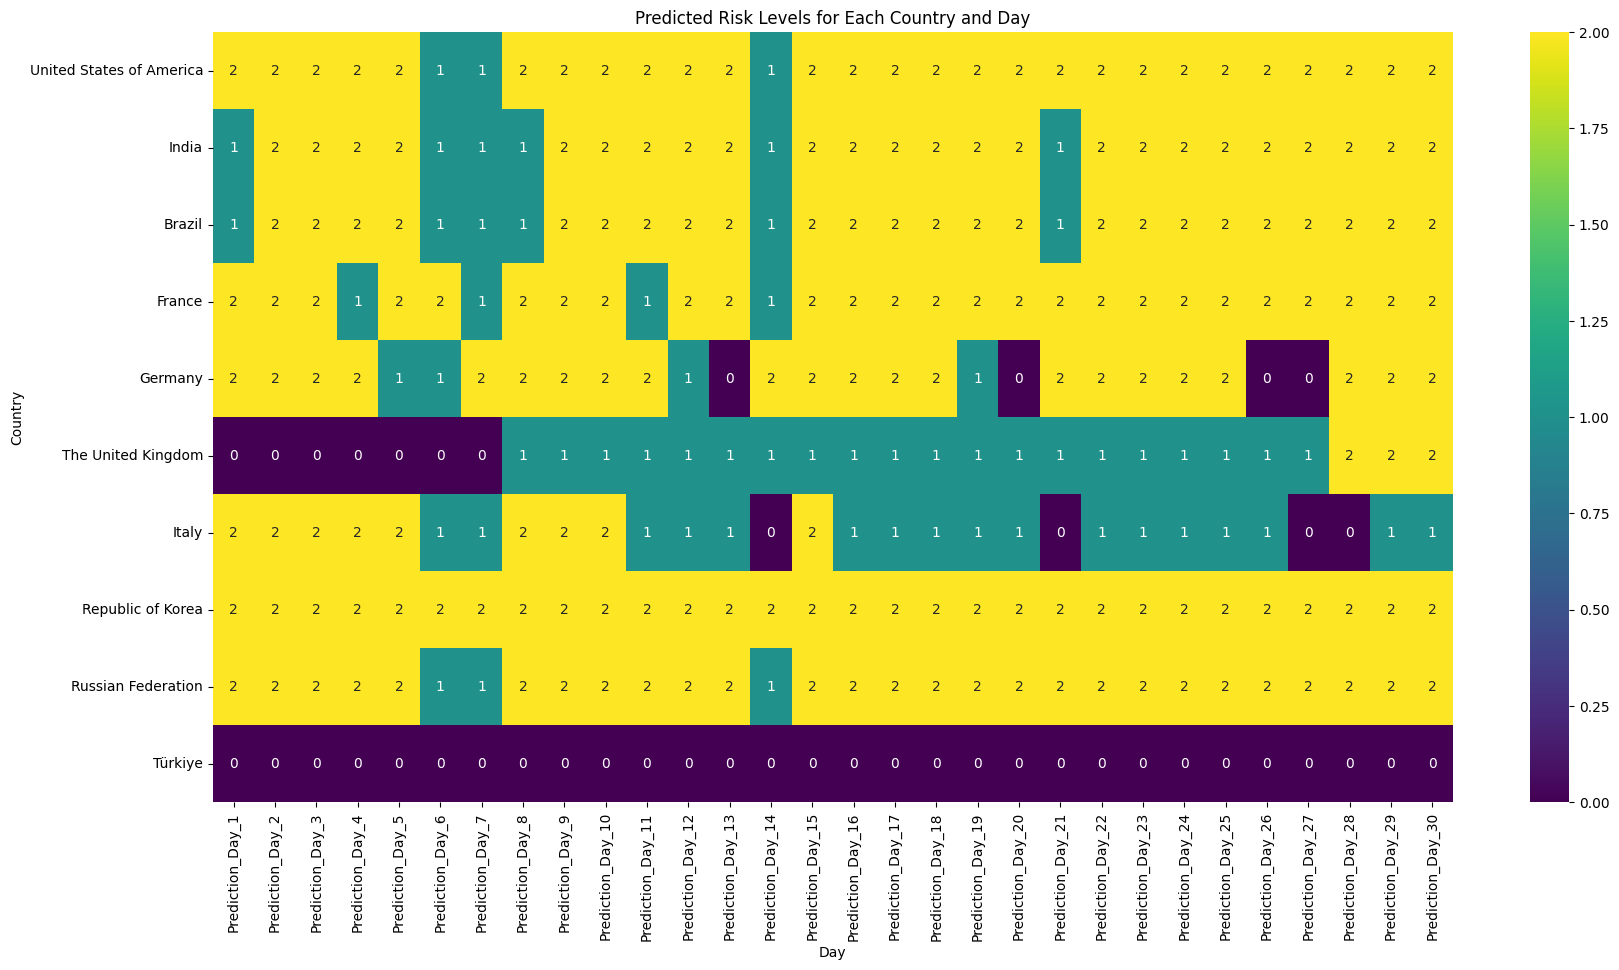

In [ ]:
# Loading the combined dataset
df = combined_df

# Describe the role of classification.
def categorize_risk(number_of_cases):
    threshold_low = 10000
    threshold_high = 60000
    if number_of_cases < threshold_low:
        return 'Low Risk'
    elif number_of_cases < threshold_high:
        return 'Moderate Risk'
    else:
        return 'High Risk'

# Creating a DataFrame to store predictions
prediction_results = pd.DataFrame()

# Iterating over each day and perform classification
for day in [f'Day_{i}' for i in range(1, 31)]:
    X = df[['icu_100k', 'GDP_medical', 'density_1k', 'hospitals', 'pop_density']]
    y = df[day].apply(categorize_risk)

    # Spliting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Predicting on the full dataset (for visualization purpose)
    df[f'Prediction_{day}'] = clf.predict(X)

    # Storing the predictions in the DataFrame
    prediction_results[f'Prediction_{day}'] = df[f'Prediction_{day}']

# Including national names in the DataFrame of the prediction results
prediction_results['Country'] = df['Country']

# Setting 'Country' as the index
prediction_results.set_index('Country', inplace=True)

# Plotting the combined heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(prediction_results.applymap(lambda x: ['Low Risk', 'Moderate Risk', 'High Risk'].index(x)), annot=True, fmt='g', cmap='viridis')
plt.title('Predicted Risk Levels for Each Country and Day')
plt.xlabel('Day')
plt.ylabel('Country')
plt.show()


In [ ]:
#Attempt 3
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.preprocessing import LabelEncoder

# df = combined_df

# # Categorize the number of cases into risk levels (this will depend on your specific criteria)
# # For example, using quantiles:
# risk_levels = pd.qcut(df['New_cases'], q=[0, .33, .66, 1], labels=['Low', 'Moderate', 'High'])

# # Encode the labels into a numeric form
# label_encoder = LabelEncoder()
# risk_levels_encoded = label_encoder.fit_transform(risk_levels)

# # Split the data into features and target
# X = df[['pop_density', 'hospitals', 'density_1k', 'GDP_medical', 'icu_100k']]  # Your feature columns
# y = risk_levels_encoded  # The encoded risk level

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train the Random Forest Classifier
# clf = RandomForestClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# # Predict on the test set
# y_pred = clf.predict(X_test)

# # Print the classification report
# print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


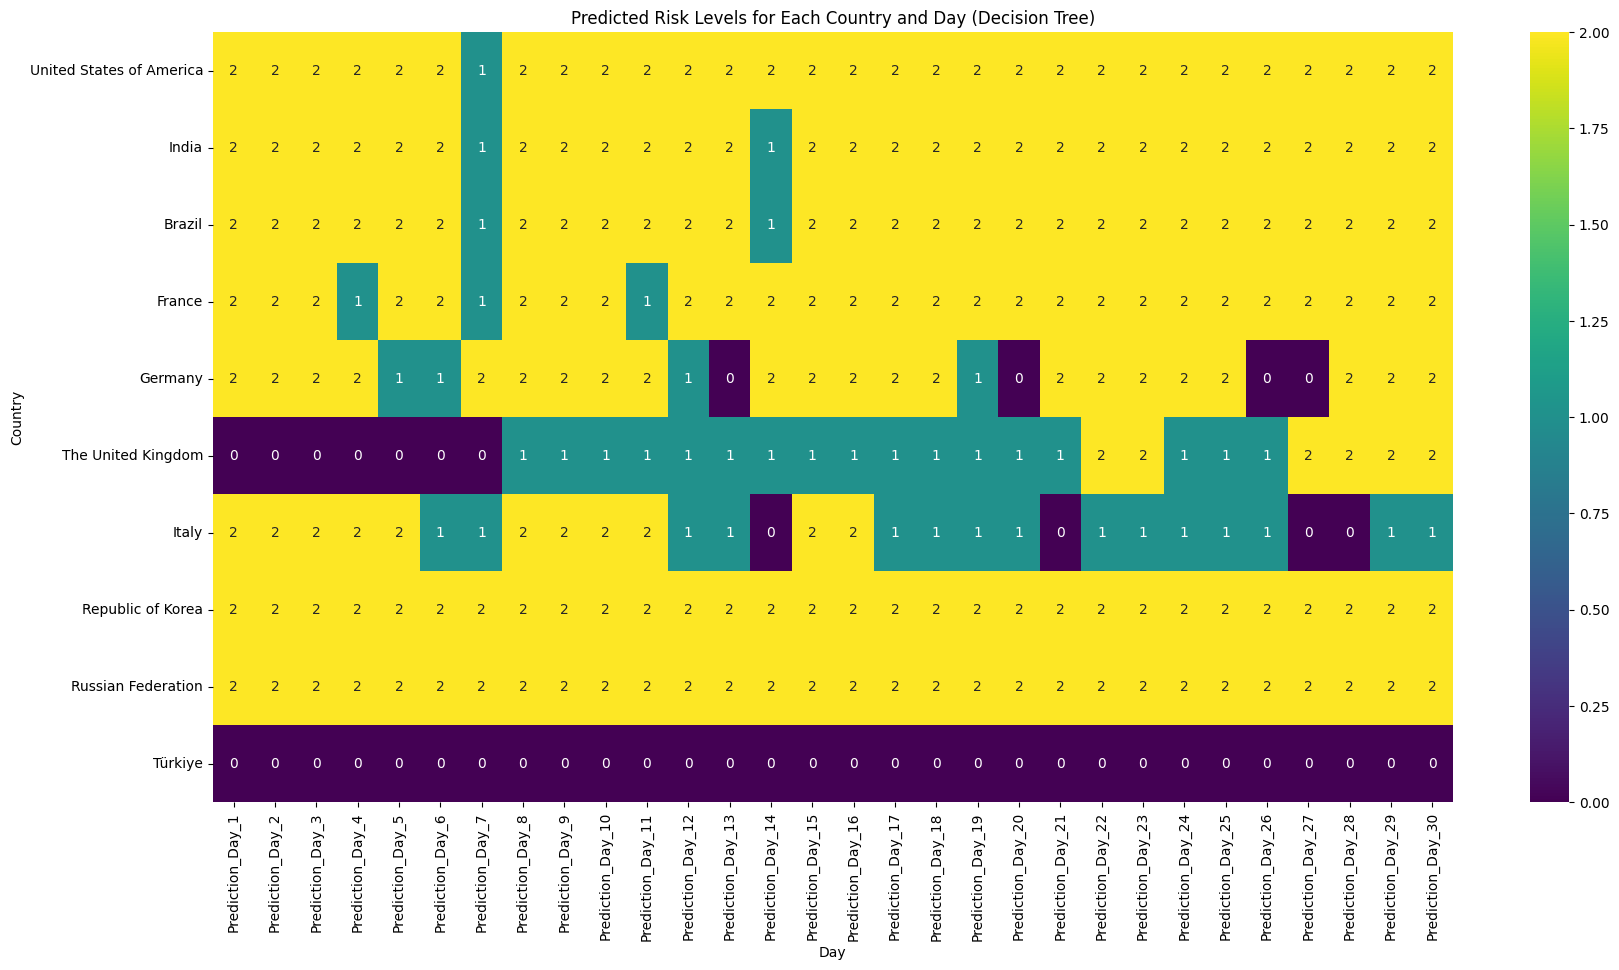

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

def categorize_risk(number_of_cases):
    threshold_low = 10000  # threshold for low risk
    threshold_high = 50000  # threshold for moderate risk
    if number_of_cases < threshold_low:
        return 'Low Risk'
    elif number_of_cases < threshold_high:
        return 'Moderate Risk'
    else:
        return 'High Risk'

# Creating a DataFrame to store predictions
prediction_results = pd.DataFrame()

# Iterating over each day and perform classification
for day in [f'Day_{i}' for i in range(1, 31)]:
    X = df[['icu_100k', 'GDP_medical', 'density_1k', 'hospitals', 'pop_density']]
    y = df[day].apply(categorize_risk)

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Estimating using the entire dataset (for sake of visualisation)
    df[f'Prediction_{day}'] = clf.predict(X)

    # Preserving the forecasts within the DataFrame
    prediction_results[f'Prediction_{day}'] = df[f'Prediction_{day}']

# Including national names in the DataFrame of the prediction results
prediction_results['Country'] = df['Country']

# Setting 'Country' as the index
prediction_results.set_index('Country', inplace=True)

# Plotting the combined heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(prediction_results.applymap(lambda x: ['Low Risk', 'Moderate Risk', 'High Risk'].index(x)), annot=True, fmt='g', cmap='viridis')
plt.title('Predicted Risk Levels for Each Country and Day (Decision Tree)')
plt.xlabel('Day')
plt.ylabel('Country')
plt.show()

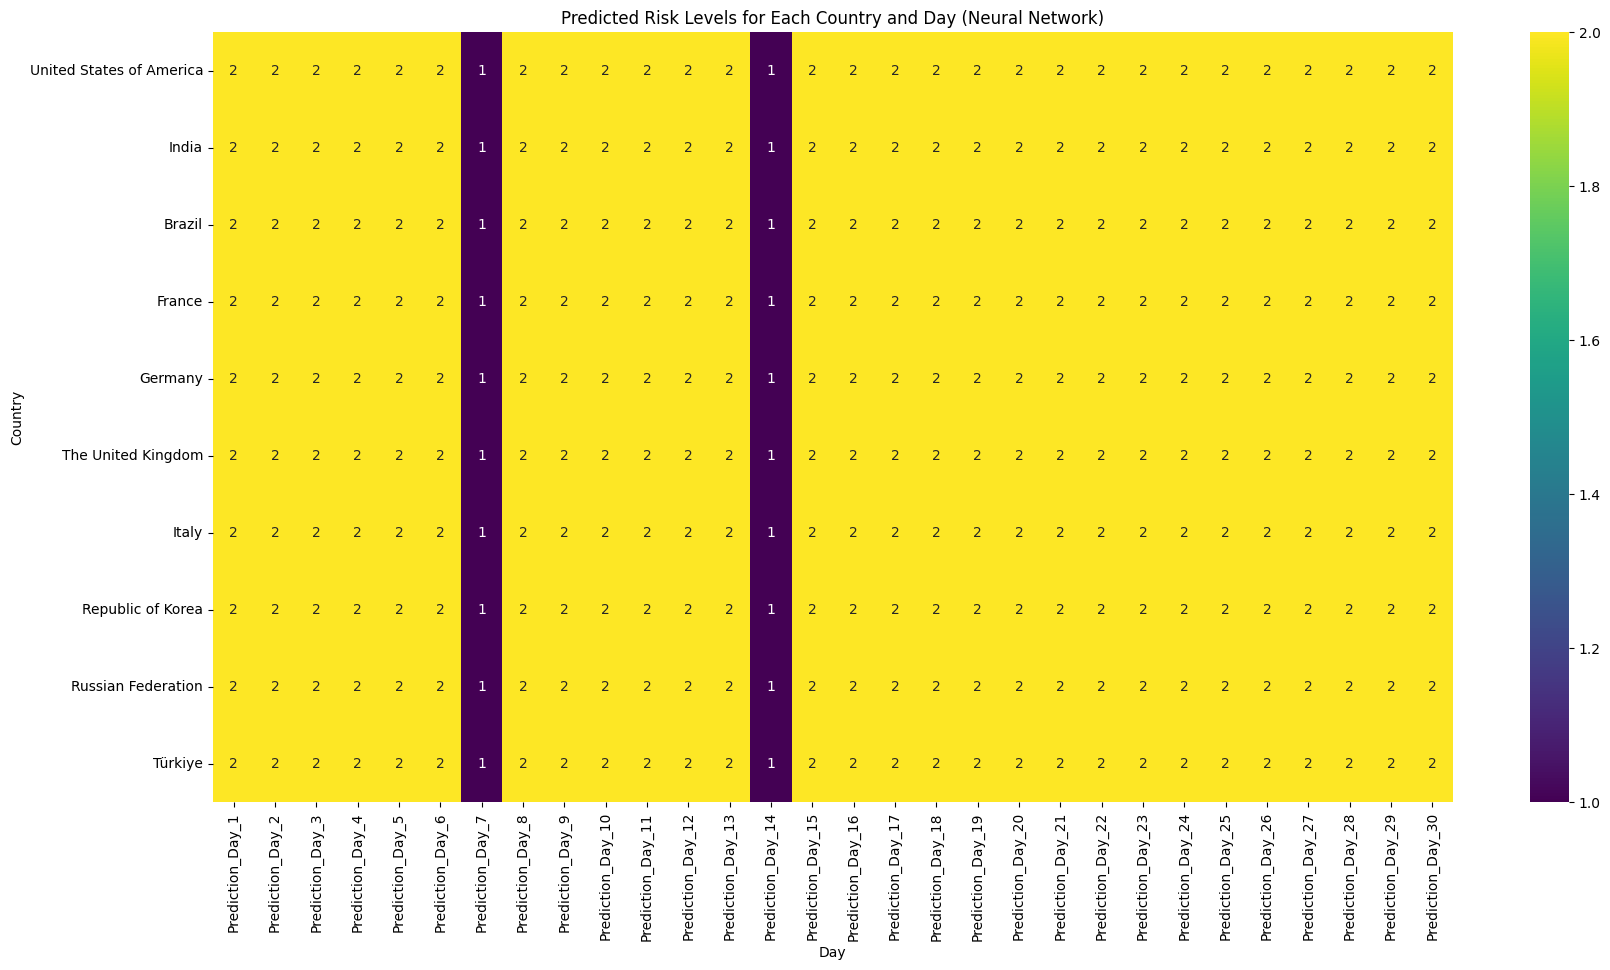

In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


# Defining the classification function using the selected methodology
def categorize_risk(number_of_cases):
    threshold_low = 10000  # Threshold for low risk
    threshold_high = 50000  # Threshold for moderate risk
    if number_of_cases < threshold_low:
        return 'Low Risk'
    elif number_of_cases < threshold_high:
        return 'Moderate Risk'
    else:
        return 'High Risk'

# Creatign a DataFrame to store predictions
prediction_results = pd.DataFrame()

# Labelling encoding for the target variable
le = LabelEncoder()

# Iterating over each day and perform classification
for day in [f'Day_{i}' for i in range(1, 31)]:
    X = df[['icu_100k', 'GDP_medical', 'density_1k', 'hospitals', 'pop_density']]
    y = df[day].apply(categorize_risk)
    y_encoded = le.fit_transform(y)  # Encode labels to integers for neural network

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Training the classifier
    clf = MLPClassifier(hidden_layer_sizes=(100,), random_state=42, max_iter=300)
    clf.fit(X_train, y_train)

    # Predicting on the full dataset (for visualization purpose)
    df[f'Prediction_{day}'] = le.inverse_transform(clf.predict(X))  # Inverse transform to get original labels

    # Storing the predictions in the DataFrame
    prediction_results[f'Prediction_{day}'] = df[f'Prediction_{day}']

# Including national names in the DataFrame of the prediction results
prediction_results['Country'] = df['Country']

# Setting 'Country' as the index
prediction_results.set_index('Country', inplace=True)

# Plotting the combined heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(prediction_results.applymap(lambda x: ['Low Risk', 'Moderate Risk', 'High Risk'].index(x)), annot=True, fmt='g', cmap='viridis')
plt.title('Predicted Risk Levels for Each Country and Day (Neural Network)')
plt.xlabel('Day')
plt.ylabel('Country')
plt.show()


Training model on New Deaths

In [ ]:
daily_death_cases = who_covid_data.groupby('Date_reported')['New_deaths'].sum().reset_index()
daily_death_cases.head()

,Date_reported,New_deaths
0,2020-01-03,0
1,2020-01-04,0
2,2020-01-05,0
3,2020-01-06,0
4,2020-01-07,0


In [ ]:
# Considering 'New_deaths' is the target variable
death_data = daily_death_cases['New_deaths'].values
death_data = death_data.reshape(-1, 1)

# Scaling the death data using the same scaler from the previous code
death_data_scaled = scaler.transform(death_data)


LSTM - New Deaths

In [ ]:
# Splitting into train and test sets
train_size_death = int(len(death_data_scaled) * 0.80)
test_size_death = len(death_data_scaled) - train_size_death
train_death, test_death = death_data_scaled[0:train_size_death,:], death_data_scaled[train_size_death:len(death_data_scaled),:]


In [ ]:
# Converting an array of values into a dataset matrix
def create_dataset_death(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
# Reshaping into X=t and Y=t+1
look_back_death = 14
X_train_death, Y_train_death = create_dataset_death(train_death, look_back_death)
X_test_death, Y_test_death = create_dataset_death(test_death, look_back_death)

# Reshaping input to be [samples, time steps, features]
X_train_death = np.reshape(X_train_death, (X_train_death.shape[0], 1, X_train_death.shape[1]))
X_test_death = np.reshape(X_test_death, (X_test_death.shape[0], 1, X_test_death.shape[1]))

Epoch 1/100
49/49 - 3s - loss: 0.0012 - 3s/epoch - 57ms/step
Epoch 2/100
49/49 - 0s - loss: 3.2543e-04 - 117ms/epoch - 2ms/step
Epoch 3/100
49/49 - 0s - loss: 1.6924e-04 - 118ms/epoch - 2ms/step
Epoch 4/100
49/49 - 0s - loss: 1.5159e-04 - 128ms/epoch - 3ms/step
Epoch 5/100
49/49 - 0s - loss: 1.5200e-04 - 141ms/epoch - 3ms/step
Epoch 6/100
49/49 - 0s - loss: 1.3517e-04 - 137ms/epoch - 3ms/step
Epoch 7/100
49/49 - 0s - loss: 1.3186e-04 - 136ms/epoch - 3ms/step
Epoch 8/100
49/49 - 0s - loss: 1.1272e-04 - 134ms/epoch - 3ms/step
Epoch 9/100
49/49 - 0s - loss: 1.1596e-04 - 132ms/epoch - 3ms/step
Epoch 10/100
49/49 - 0s - loss: 1.1158e-04 - 158ms/epoch - 3ms/step
Epoch 11/100
49/49 - 0s - loss: 1.1065e-04 - 144ms/epoch - 3ms/step
Epoch 12/100
49/49 - 0s - loss: 9.8805e-05 - 147ms/epoch - 3ms/step
Epoch 13/100
49/49 - 0s - loss: 1.0014e-04 - 134ms/epoch - 3ms/step
Epoch 14/100
49/49 - 0s - loss: 9.2838e-05 - 116ms/epoch - 2ms/step
Epoch 15/100
49/49 - 0s - loss: 9.0327e-05 - 117ms/epoch - 2ms/

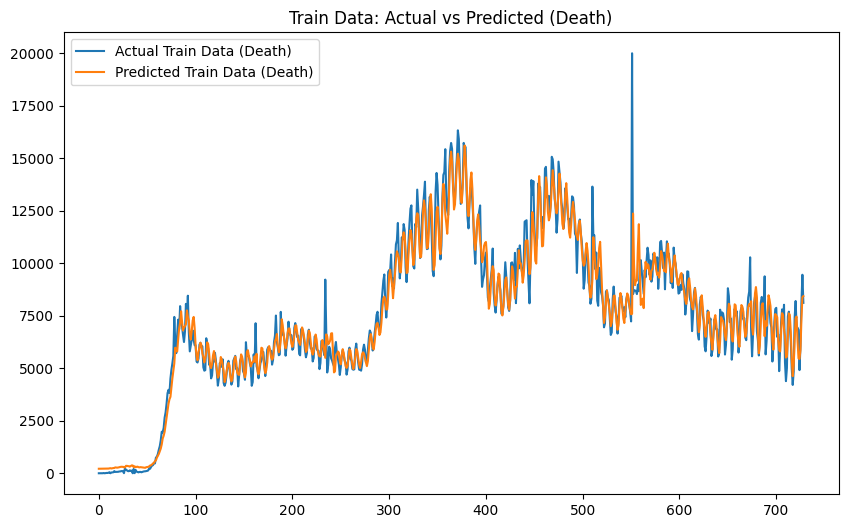

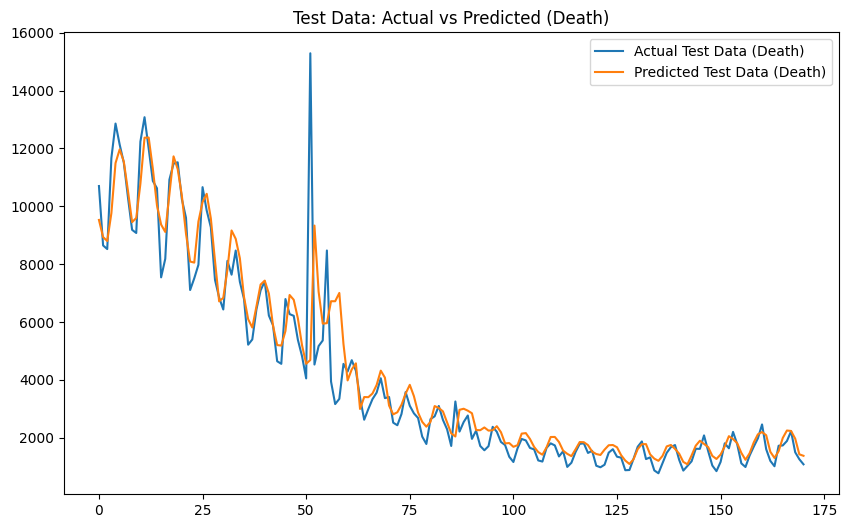

In [ ]:
# Creating and fitting the LSTM network for death data
model_death = Sequential()
model_death.add(LSTM(50, return_sequences=True, input_shape=(1, look_back_death)))
model_death.add(Dropout(0.2))
model_death.add(LSTM(50))
model_death.add(Dropout(0.2))
model_death.add(Dense(1))
model_death.compile(loss='mean_squared_error', optimizer='adam')

# Training the model for death data
model_death.fit(X_train_death, Y_train_death, epochs=100, batch_size=15, verbose=2)

# Making predictions for death data
train_predict_death = model_death.predict(X_train_death)
test_predict_death = model_death.predict(X_test_death)

# Inverting predictions to original scale for death data
train_predict_death = scaler.inverse_transform(train_predict_death)
Y_train_death_inverted = scaler.inverse_transform([Y_train_death])
test_predict_death = scaler.inverse_transform(test_predict_death)
Y_test_death_inverted = scaler.inverse_transform([Y_test_death])

# Calculating RMSE for death data
train_score_death = np.sqrt(mean_squared_error(Y_train_death_inverted[0], train_predict_death[:, 0]))
test_score_death = np.sqrt(mean_squared_error(Y_test_death_inverted[0], test_predict_death[:, 0]))
print(f'Train Score for Death Data: {train_score_death:.2f} RMSE')
print(f'Test Score for Death Data: {test_score_death:.2f} RMSE')

# Calculating MAPE and Accuracy for death data
mape_train_death = mean_absolute_percentage_error(Y_train_death_inverted[0], train_predict_death[:, 0])
mape_test_death = mean_absolute_percentage_error(Y_test_death_inverted[0], test_predict_death[:, 0])
accuracy_train_death = 100 - mape_train_death * 100
accuracy_test_death = 100 - mape_test_death * 100
print(f'Train Accuracy for Death Data: {accuracy_train_death:.2f}%')
print(f'Test Accuracy for Death Data: {accuracy_test_death:.2f}%')

# Plotting Predictions vs Actual Data for death data
plt.figure(figsize=(10,6))
plt.plot(Y_train_death_inverted[0], label='Actual Train Data (Death)')
plt.plot(train_predict_death[:, 0], label='Predicted Train Data (Death)')
plt.title('Train Data: Actual vs Predicted (Death)')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(Y_test_death_inverted[0], label='Actual Test Data (Death)')
plt.plot(test_predict_death[:, 0], label='Predicted Test Data (Death)')
plt.title('Test Data: Actual vs Predicted (Death)')
plt.legend()
plt.show()


Performing prophet model on log of new deaths

DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/1shax7a7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/um_sd36o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14046', 'data', 'file=/tmp/tmp8r5lp1il/1shax7a7.json', 'init=/tmp/tmp8r5lp1il/um_sd36o.json', 'output', 'file=/tmp/tmp8r5lp1il/prophet_modelat80hskw/prophet_model-20231211202311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:23:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


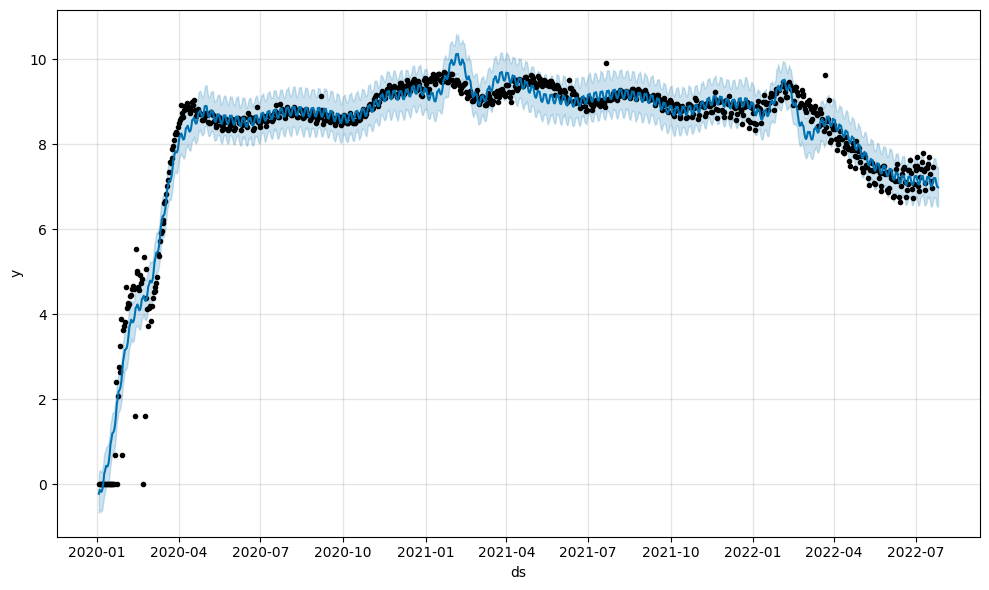

In [ ]:
import pandas as pd
from prophet import Prophet

# Considering that initial DataFrame with "Date_reported" and "New_deaths" is daily_death_cases
# If not, replacing it with your actual DataFrame
death_data_log = daily_death_cases[['Date_reported', 'New_deaths']].copy()

# Taking the log of 'New_deaths'
death_data_log['log_New_deaths'] = death_data_log['New_deaths'].apply(lambda x: 0 if x == 0 else np.log(x))

# Renaming columns for Prophet compatibility
death_data_log.rename(columns={'Date_reported': 'ds', 'log_New_deaths': 'y'}, inplace=True)

# Initializing and fitting Prophet model
model_prophet = Prophet(daily_seasonality=False)
model_prophet.fit(death_data_log)

# Creating a DataFrame with future dates for prediction
future = model_prophet.make_future_dataframe(periods=6)  # You can adjust the number of days into the future

# Making predictions
forecast = model_prophet.predict(future)

# Plotting the forecast
fig = model_prophet.plot(forecast)



In [ ]:
# Performing cross-validation
df_cv = cross_validation(model_prophet, horizon='6 days', parallel="processes")
# '6 days' is the horizon for the cross-validation, you can adjust it based on your requirement

# Calculating performance metrics
df_metrics = performance_metrics(df_cv)
print(df_metrics.head())

INFO:prophet:Making 186 forecasts with cutoffs between 2021-01-05 00:00:00 and 2022-07-14 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7b15bedbfaf0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/ba054yi1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/ezsx9a2a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/_f5302n6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82757', 'data', 'file=/tmp/tmp8r5lp1il/ba054yi1.json', 'init=/tmp/tmp8r5lp1il/_f5302n6.json', 'output', 'file=/tmp/tmp8r5lp1il/prophet_modelwkkcyv8c/prophet_model-20231211202318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8r5lp1il/pgy9spr_.json
D

  horizon       mse      rmse       mae      mape     mdape     smape  \
0  1 days  0.223608  0.472872  0.330563  0.037733  0.025748  0.037026   
1  2 days  0.263317  0.513145  0.359663  0.040867  0.030009  0.040110   
2  3 days  0.309385  0.556224  0.382800  0.043513  0.028759  0.042579   
3  4 days  0.358523  0.598768  0.404001  0.045927  0.029773  0.044849   
4  5 days  0.412275  0.642087  0.434788  0.049197  0.033898  0.048049   

   coverage  
0  0.758065  
1  0.715054  
2  0.693548  
3  0.672043  
4  0.655914  
